# **Deep Convolutional GAN**

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


# Loading Dataset

In [35]:
(X_train, y_train), (X_test, y_test)  = tf.keras.datasets.mnist.load_data()

## dataset shape

In [36]:
print(X_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


## Print data instance

3


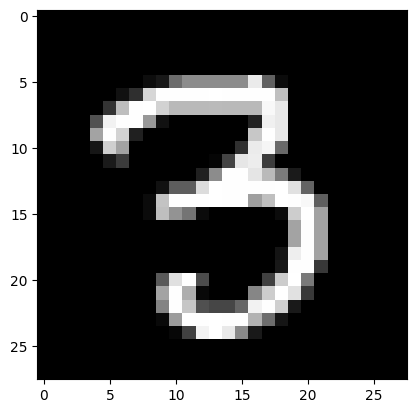

In [37]:
i = np.random.randint(0, 60000)
print(y_train[i])
plt.imshow(X_train[i], cmap='gray')

# Preprocessing

In [38]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [39]:
print(X_train.shape)

(60000, 28, 28, 1)


In [40]:
X_train = (X_train-127.5)/127.5

In [41]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [42]:
batch_size = 256
size = X_train.shape[0]

In [43]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(size).batch(batch_size)

In [44]:
print(type(X_train))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [45]:
print(X_train)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


# Generator Architecture

In [46]:
def generator():
  network = tf.keras.Sequential()
  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))
  # 7 x 7 x 128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size =(5,5), padding = 'same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14 x 14 x 64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size =(5,5), strides=(2,2), padding = 'same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  # 28 x 28 x 1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), strides=(2,2), padding = 'same', use_bias = False, activation='tanh'))
  network.summary()
  return network


### Print Architecture

In [47]:
gen = generator()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)        

In [48]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.70897454, -0.12484656,  1.3870004 , -1.447411  , -0.76552993,
         0.72966784,  1.1148512 ,  1.1987528 ,  0.58704454, -0.15461707,
        -0.22572367, -1.1582664 , -1.659768  , -0.3379652 , -0.20281576,
         1.637635  ,  1.1272587 ,  0.7311039 , -0.53820205,  0.4495948 ,
         1.3906056 , -0.98165035, -2.219341  , -0.10158695, -0.43561345,
         1.1966916 , -0.70373166,  1.6746405 ,  0.91959625, -0.9872508 ,
         0.38123563,  0.49849555,  0.38363314,  0.6612948 , -0.6200668 ,
        -0.6391821 , -1.3572901 , -0.3929696 , -1.6447725 , -0.80368793,
        -0.18311465, -0.4139508 , -0.9973149 ,  0.3380298 , -1.147278  ,
        -0.07261124,  1.0210146 , -0.5930637 , -0.10562611,  0.64984745,
         0.11630343, -0.28496382,  1.1888453 , -1.4069042 ,  0.17720895,
         0.14546362,  0.4589849 ,  0.21453011,  1.6988041 , -1.1573045 ,
         2.387833  ,  1.1232934 ,  1.0859907 ,  0.5014321 , -1.0102742 ,
 

In [49]:
generated_image = gen(noise, training = False)


In [50]:
print(generated_image.shape)

(1, 28, 28, 1)


# Random Noise Image (not Trained)

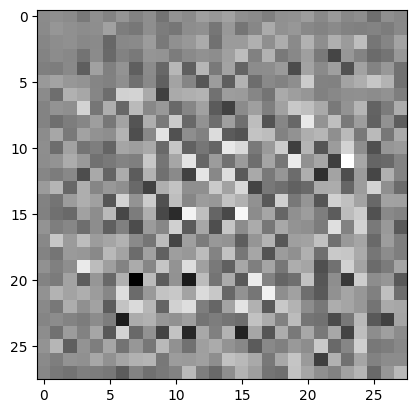

In [51]:
plt.imshow(generated_image[0,:,:,0], cmap='gray');

# Discriminator

In [52]:
def discriminator():
  network = tf.keras.Sequential()

  network.add(layers.Conv2D(filters=64, strides = (2,2), kernel_size = (5,5), padding='same' ,input_shape=(28,28,1)))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Conv2D(filters=128, strides = (2,2), kernel_size = (5,5), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network


In [53]:
dis = discriminator()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [54]:
dis.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_2_input')>

In [55]:
# When we dont specify the activation function the result will be in logit format
dis(generated_image, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00199965]], dtype=float32)>

In [56]:
tf.sigmoid(dis(generated_image))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49950007]], dtype=float32)>

## Loss Functions

In [57]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [58]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [59]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

## Tranining

In [60]:
X_train,

(<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>,)

In [61]:
epochs = 100
noise_dimension = 100
number_of_images = 16
print(batch_size)
print(noise_dimension)

256
100


In [62]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  # print(noise.shape)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = gen(noise, training=True)

    expected_output = dis(images, training=True)
    fake_output = dis(generated_images,training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, gen.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, dis.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, dis.trainable_variables))





In [63]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [64]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    print(f'epoch = {epoch+1}/{epochs}')
    for image_batch in dataset:
      # print(image_batch.shape)
      train(image_batch)
    generated_images = gen(test_images, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(generated_images[i, :, :, 0]*127.5+127.5, cmap='gray')
      plt.axis('off')
    plt.show()



epoch = 1/100


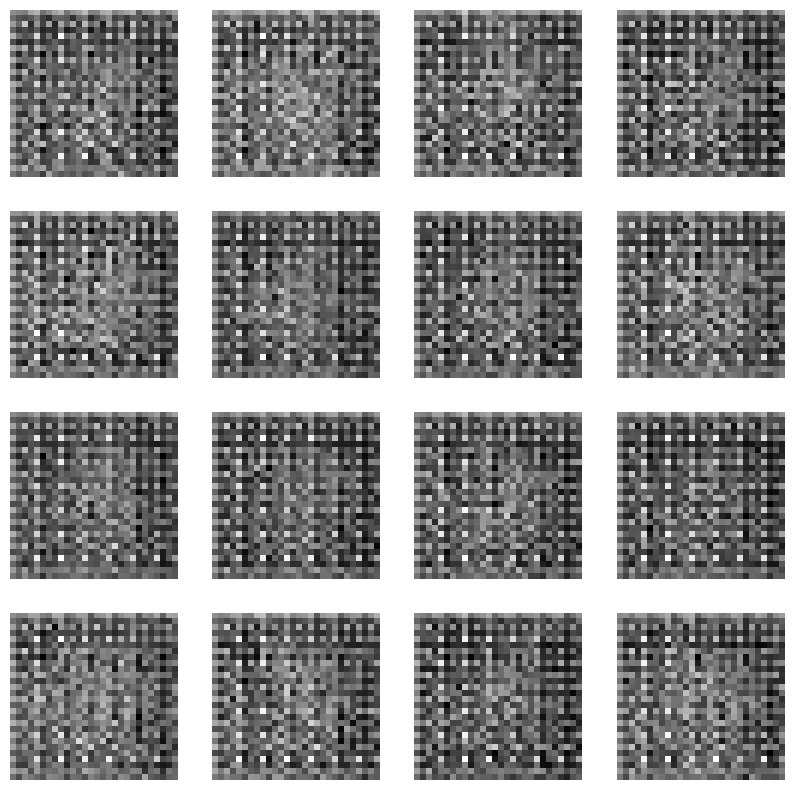

epoch = 2/100


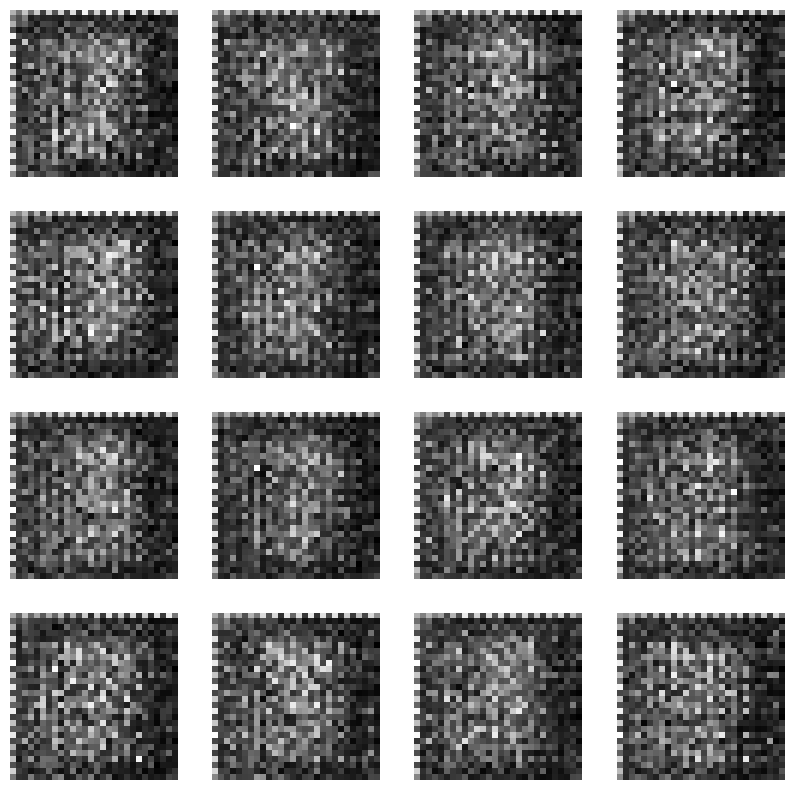

epoch = 3/100


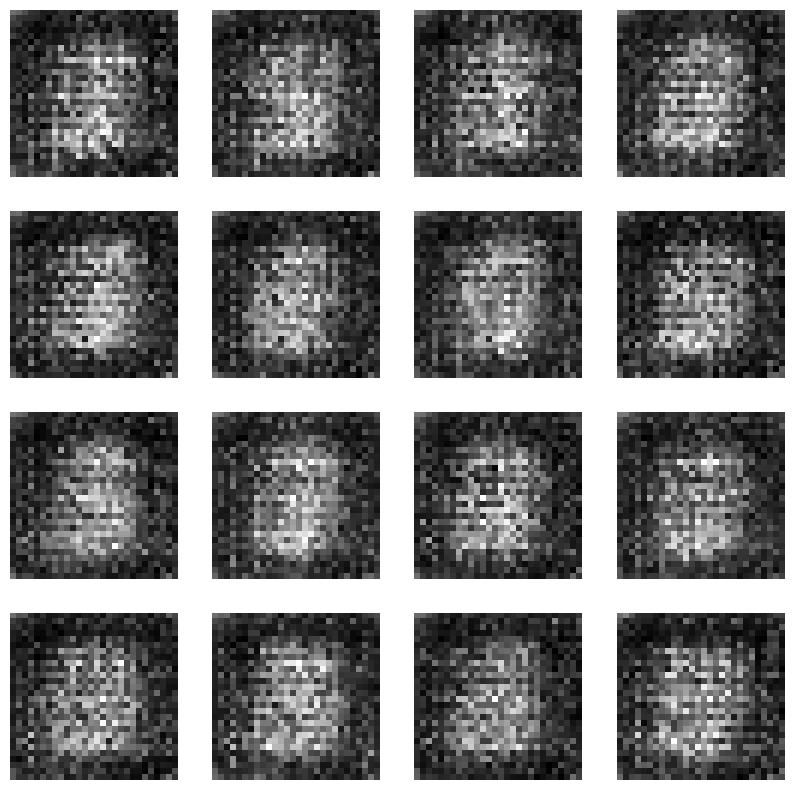

epoch = 4/100


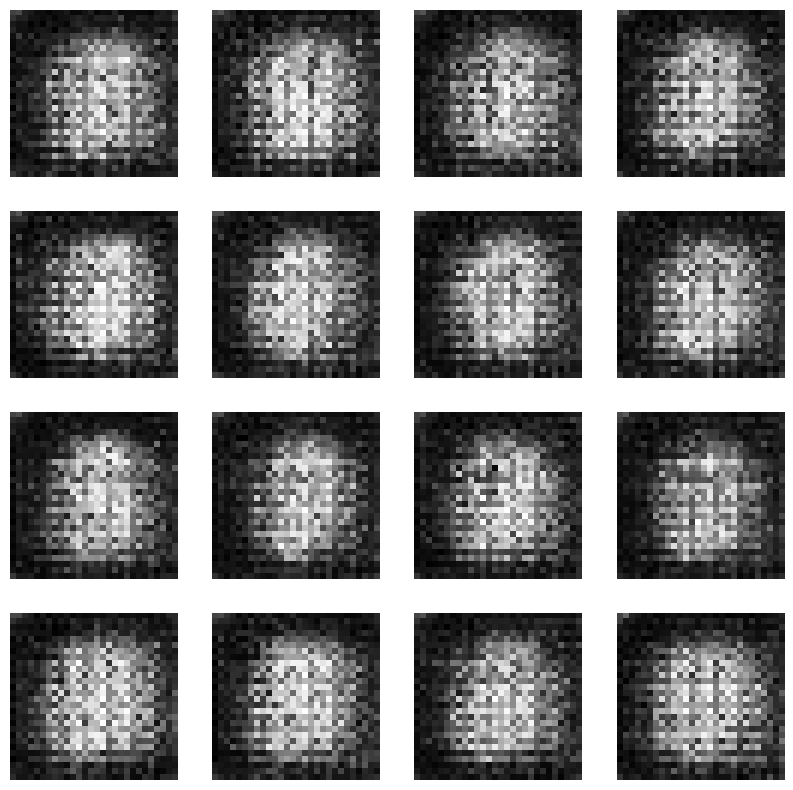

epoch = 5/100


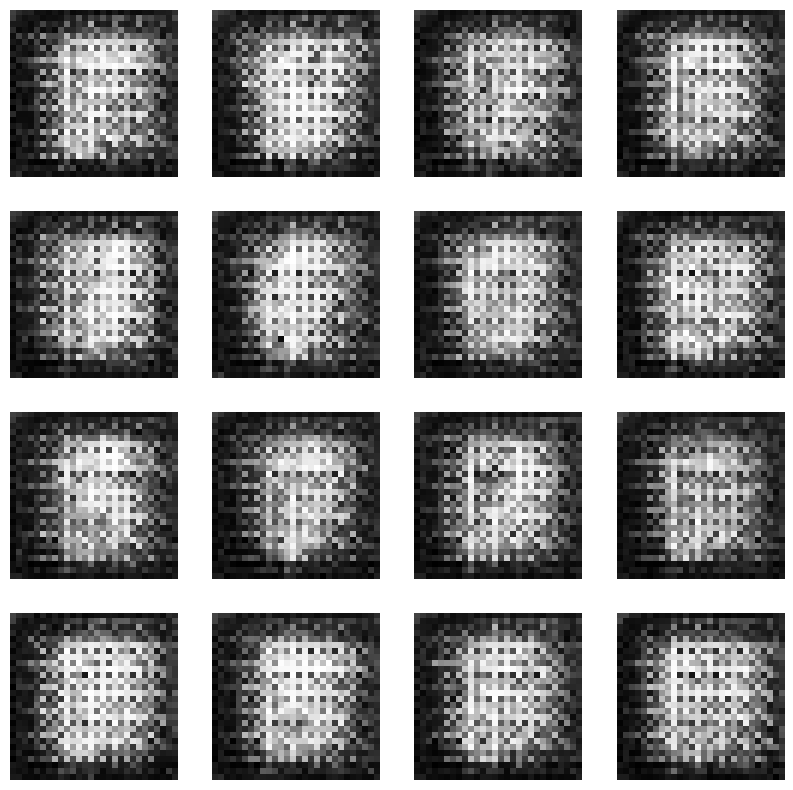

epoch = 6/100


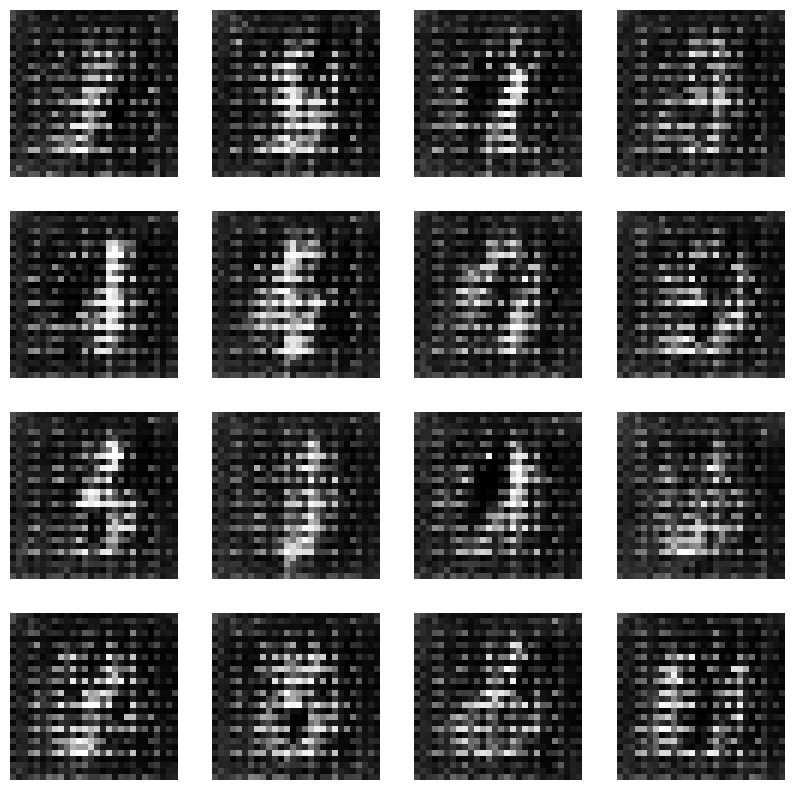

epoch = 7/100


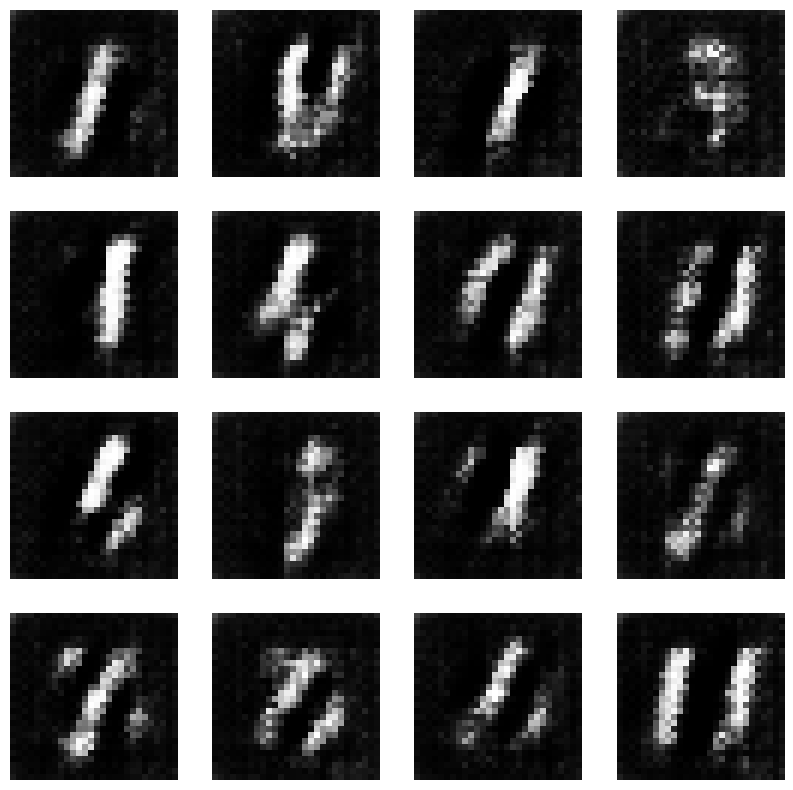

epoch = 8/100


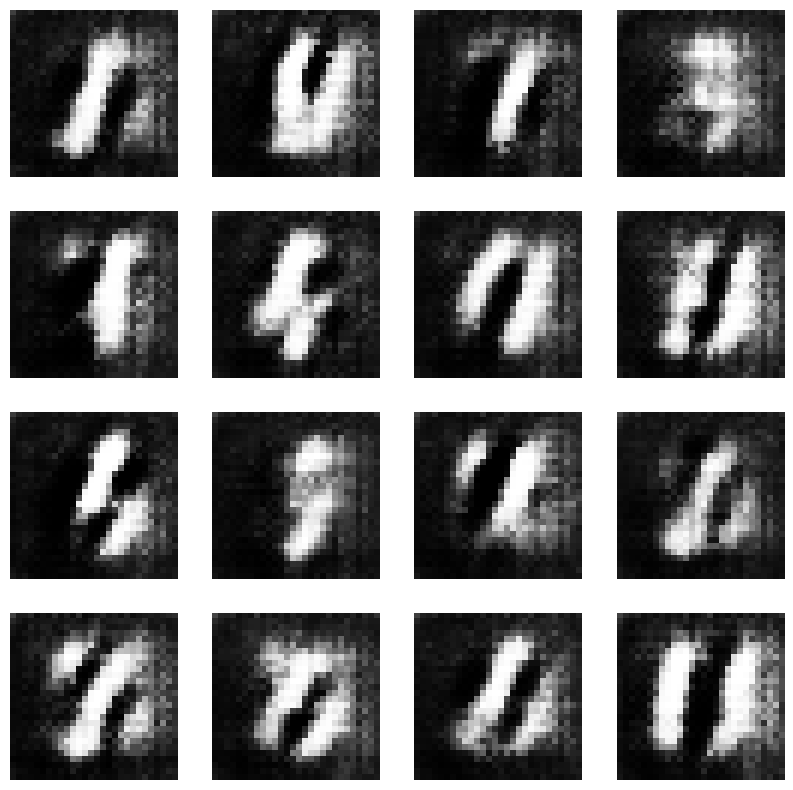

epoch = 9/100


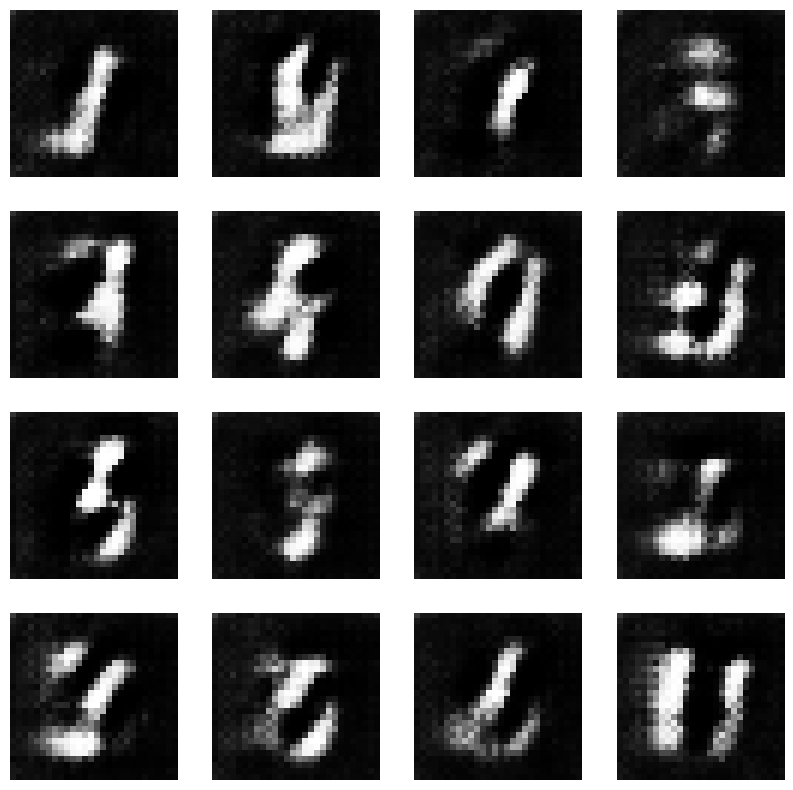

epoch = 10/100


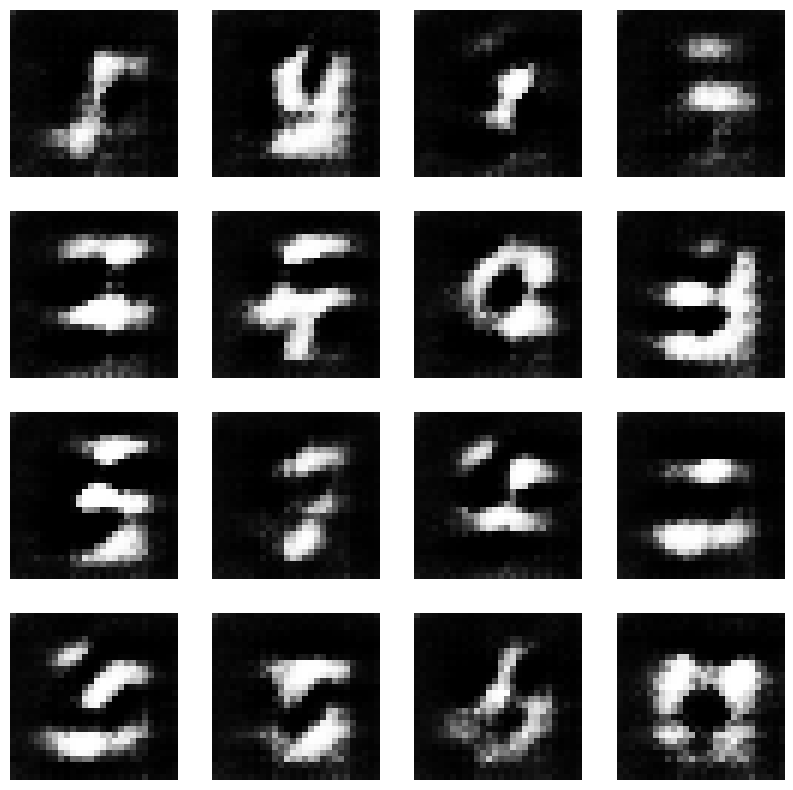

epoch = 11/100


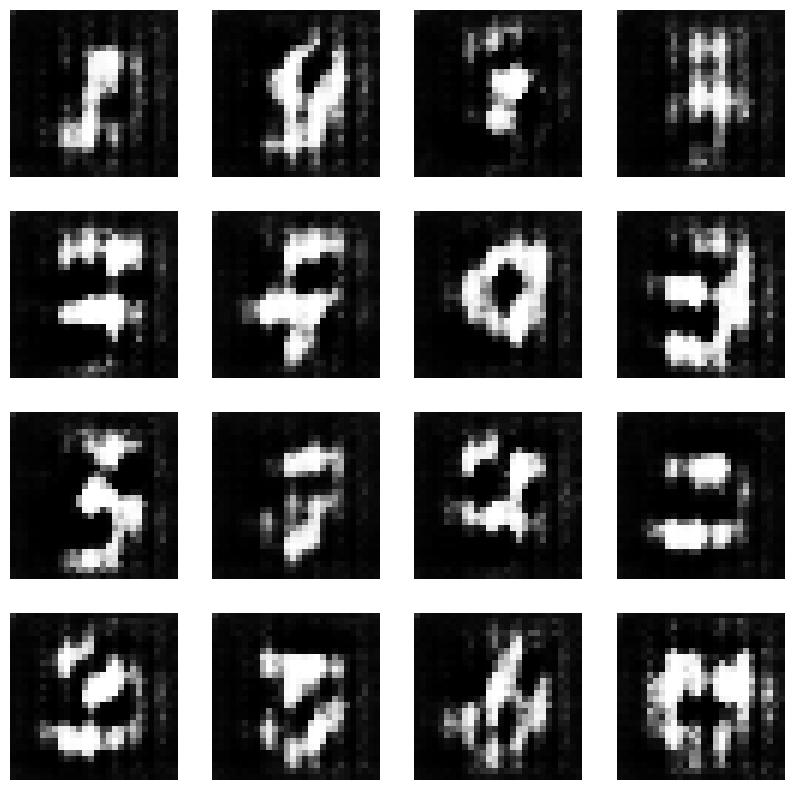

epoch = 12/100


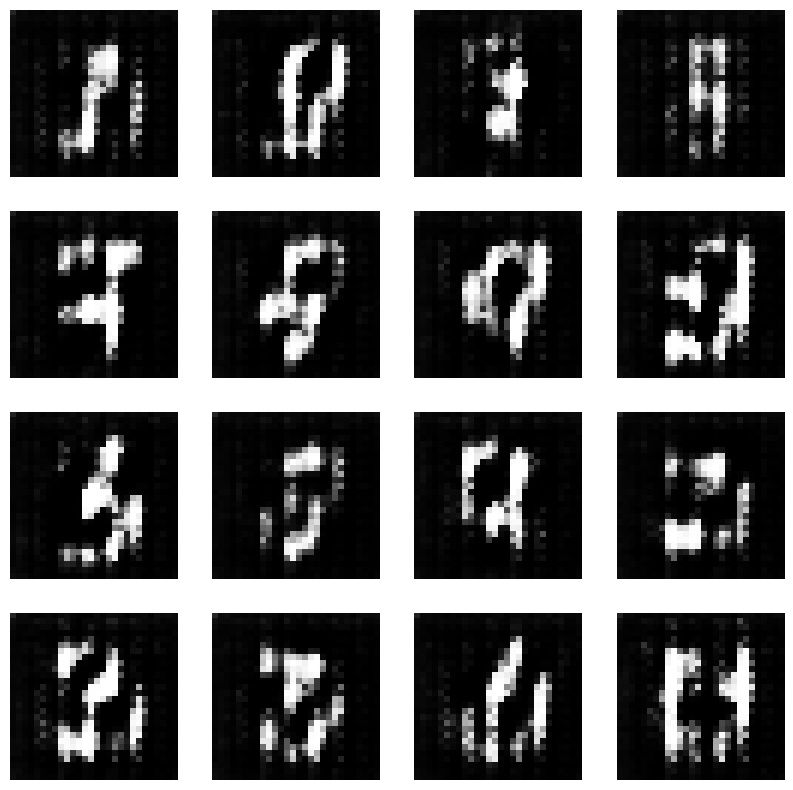

epoch = 13/100


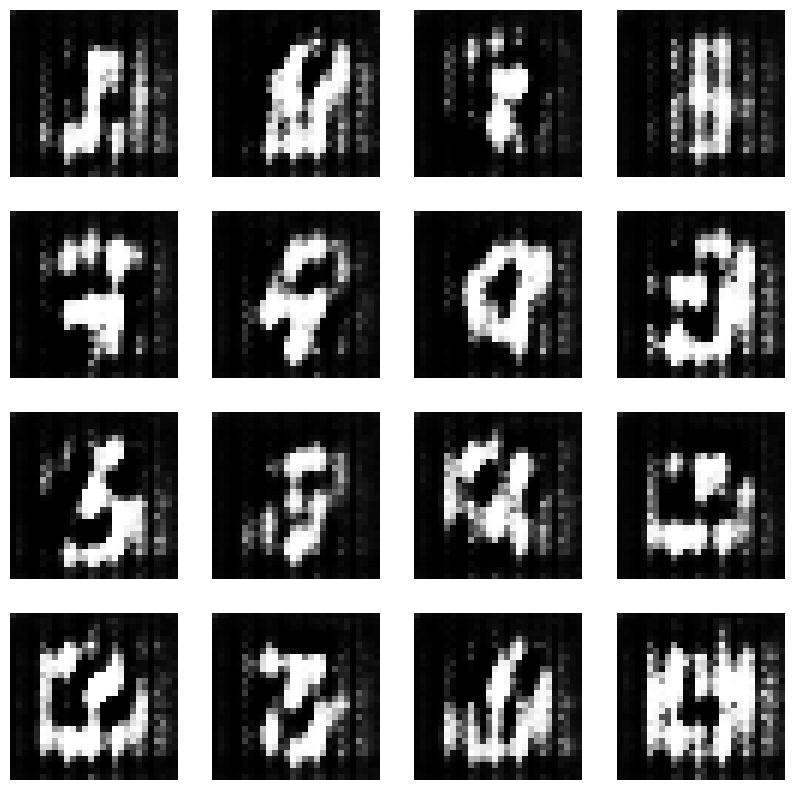

epoch = 14/100


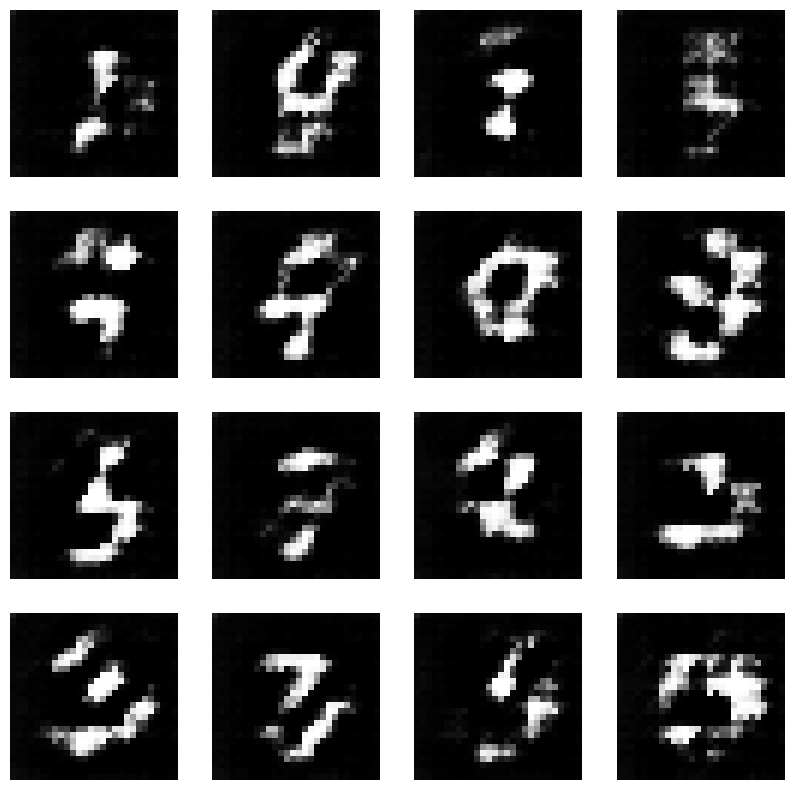

epoch = 15/100


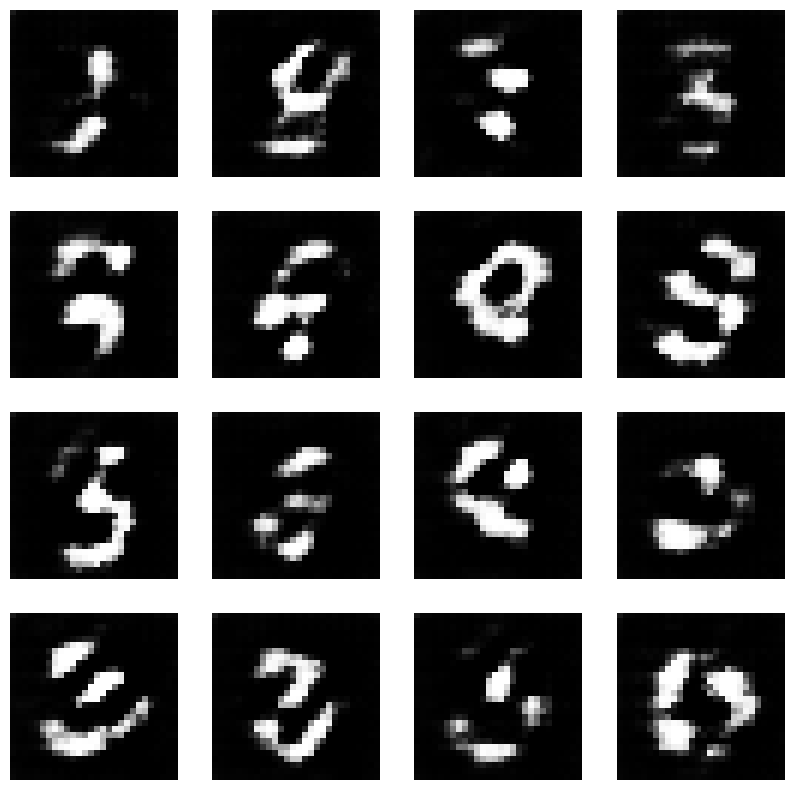

epoch = 16/100


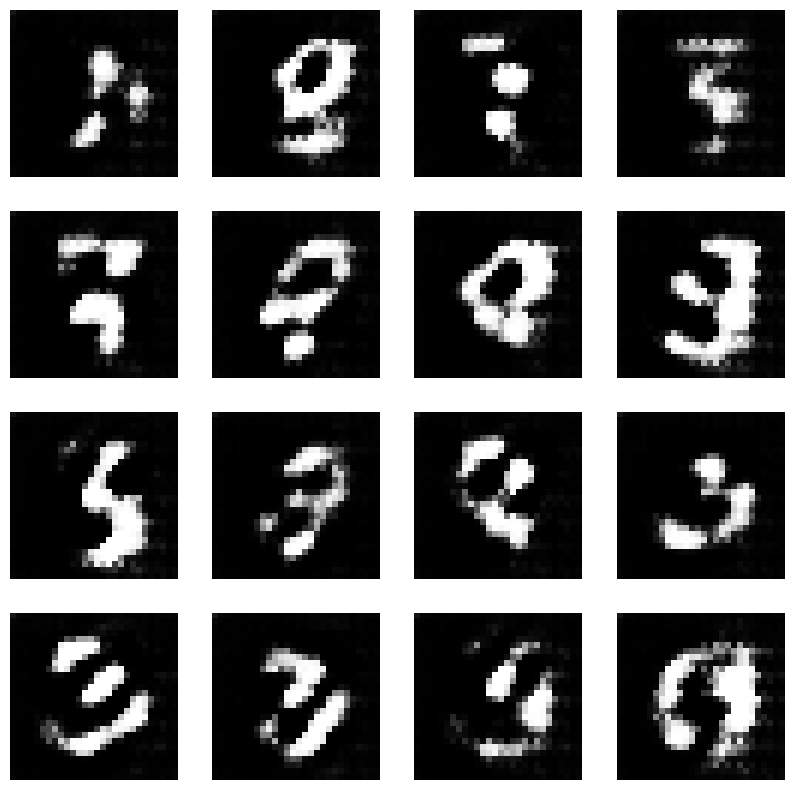

epoch = 17/100


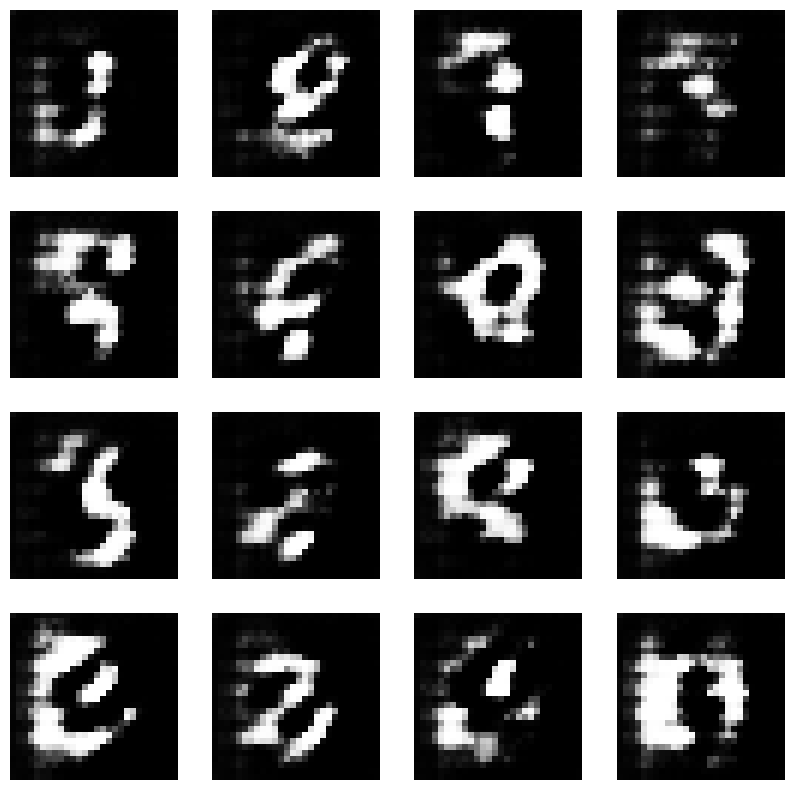

epoch = 18/100


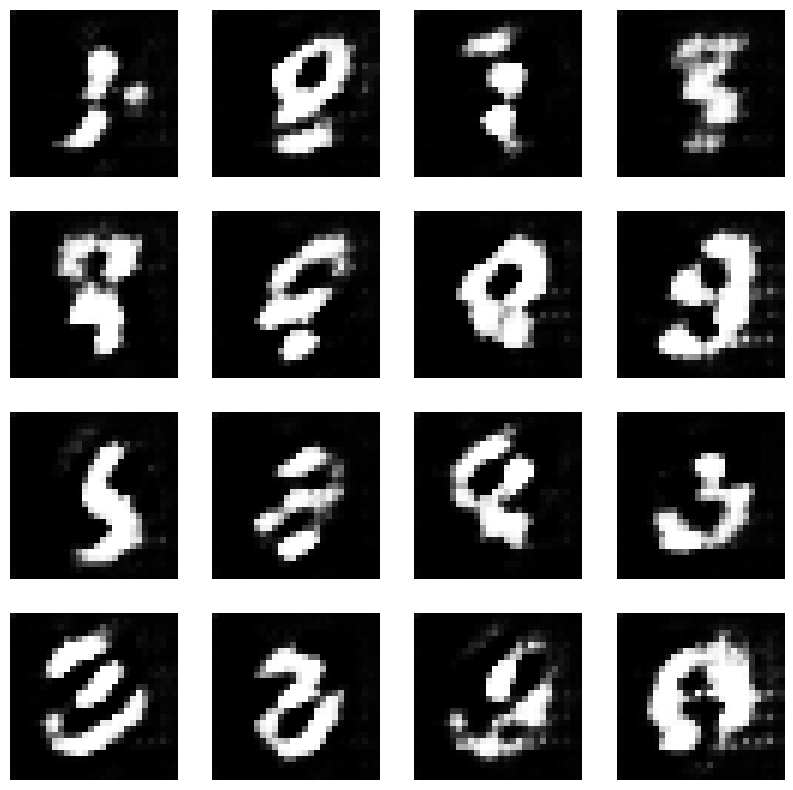

epoch = 19/100


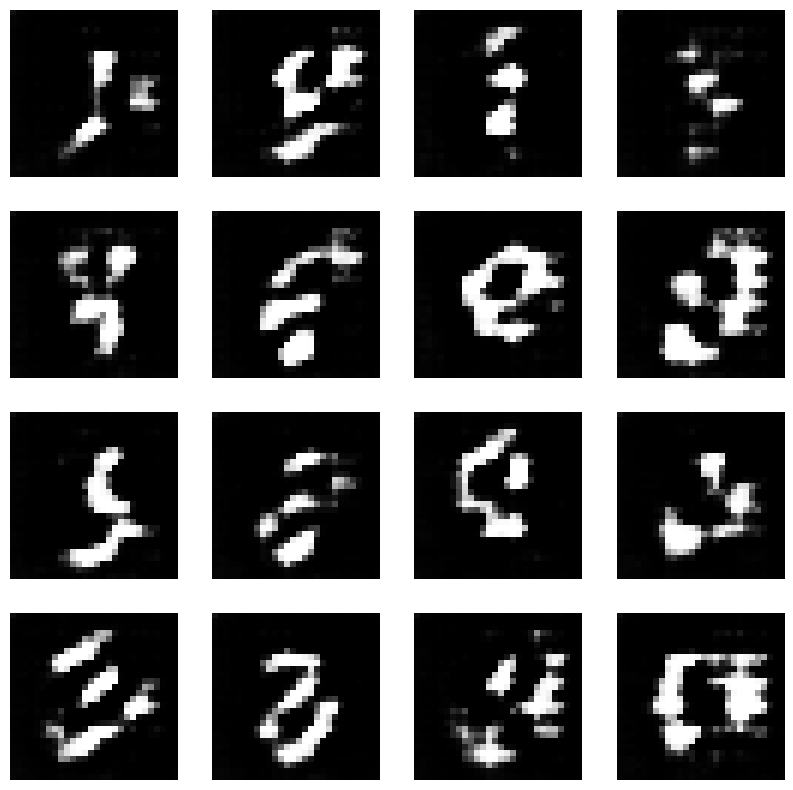

epoch = 20/100


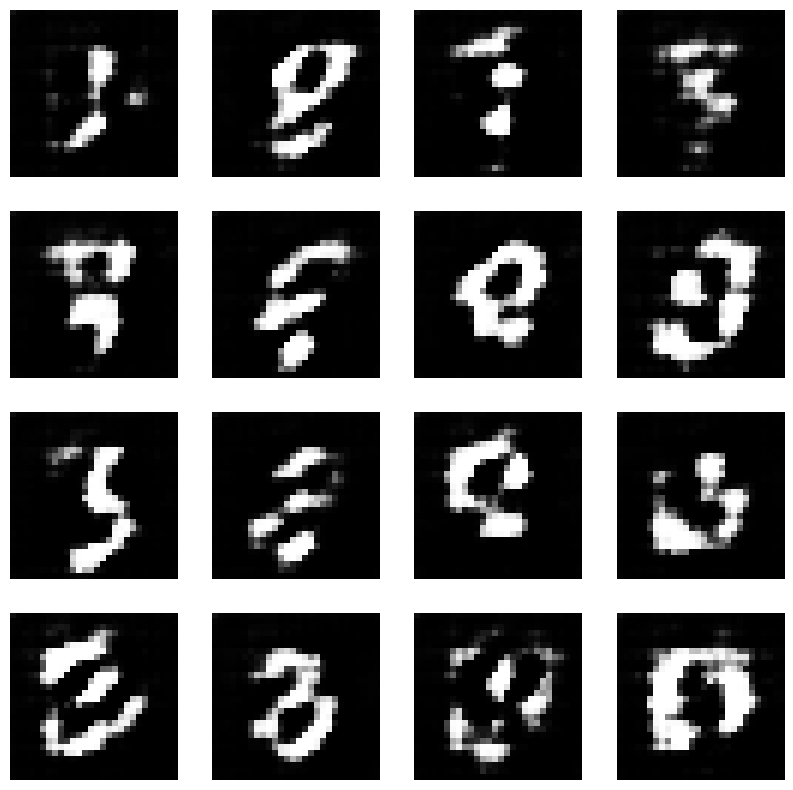

epoch = 21/100


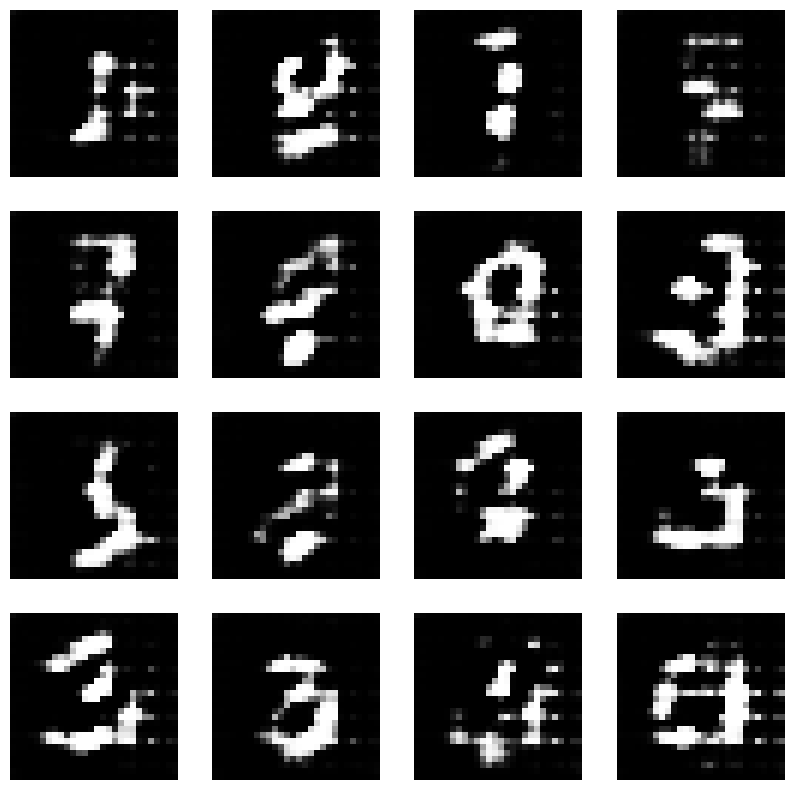

epoch = 22/100


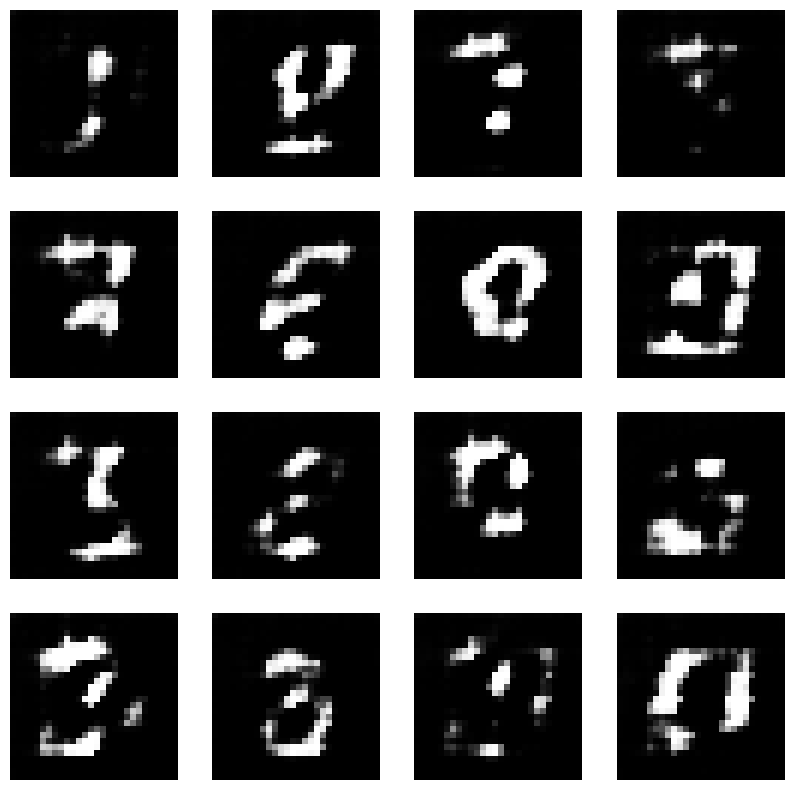

epoch = 23/100


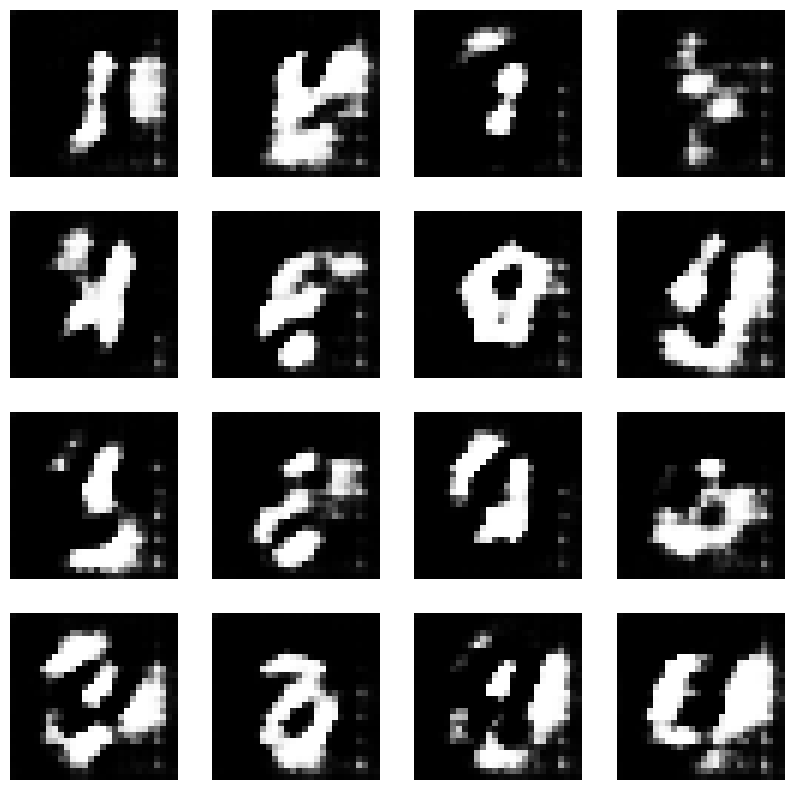

epoch = 24/100


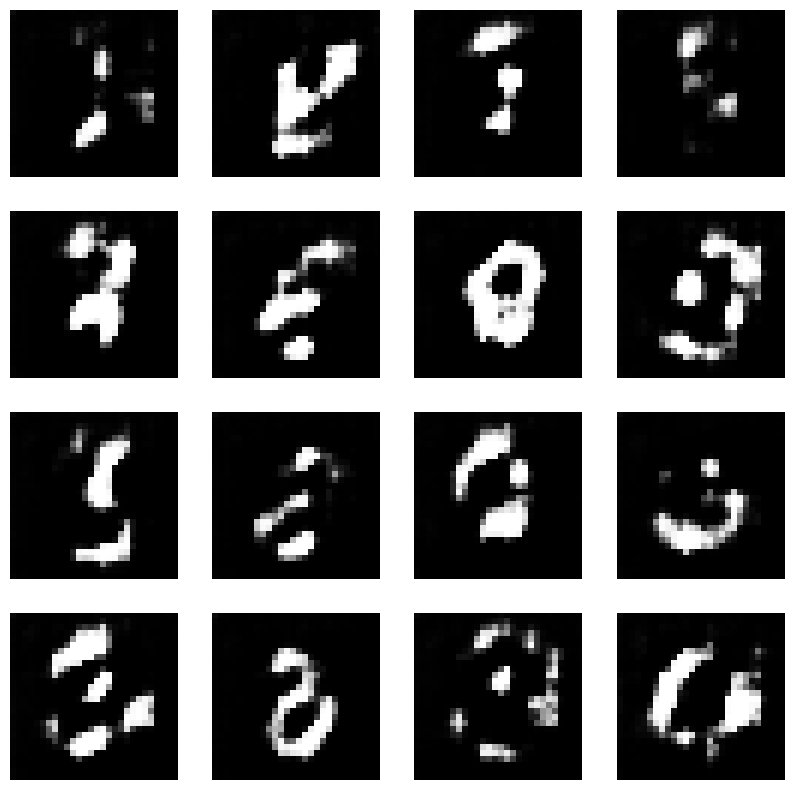

epoch = 25/100


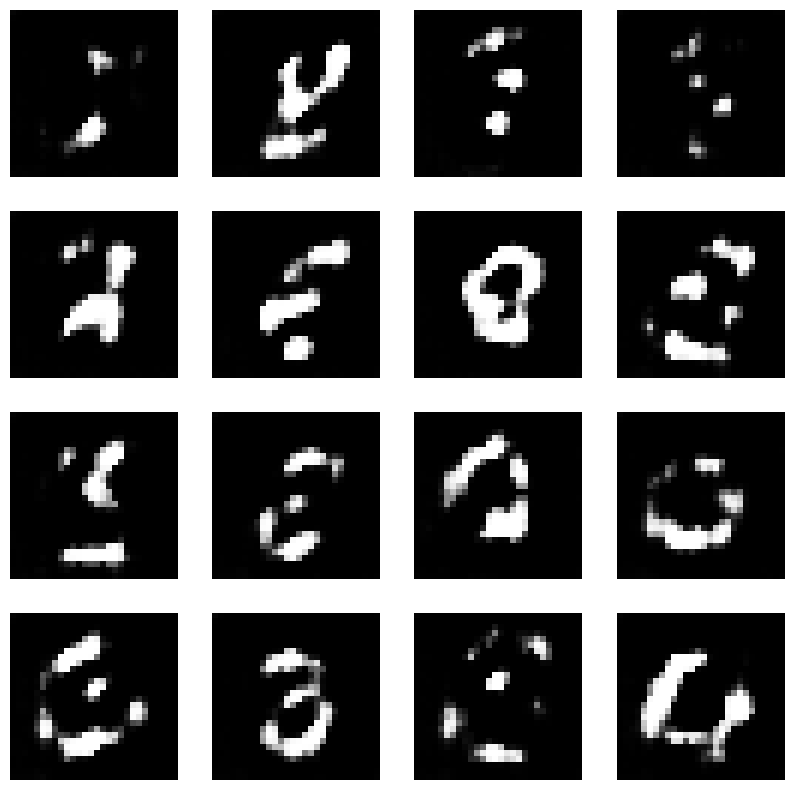

epoch = 26/100


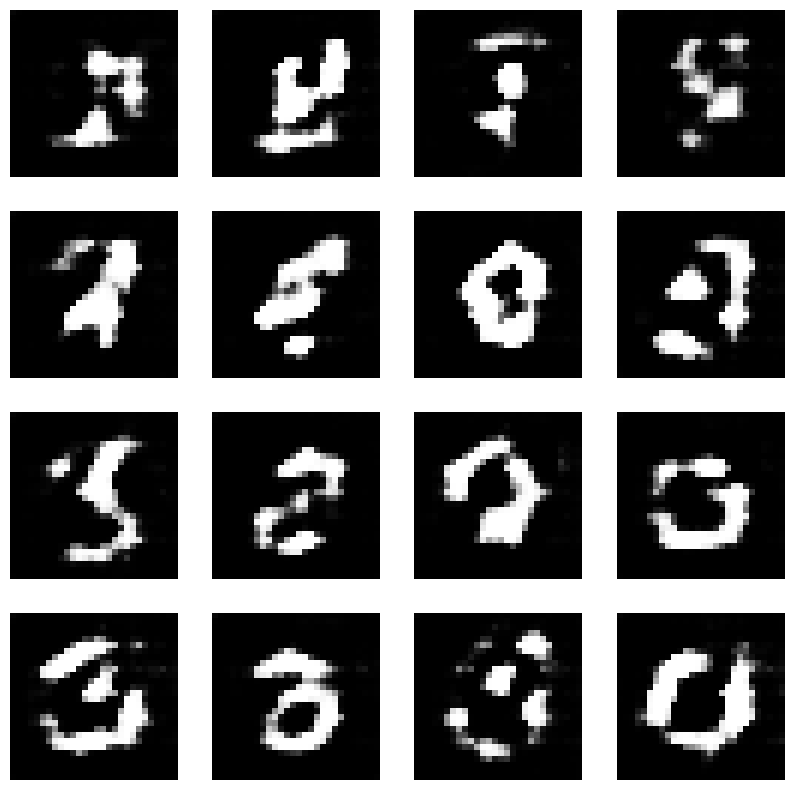

epoch = 27/100


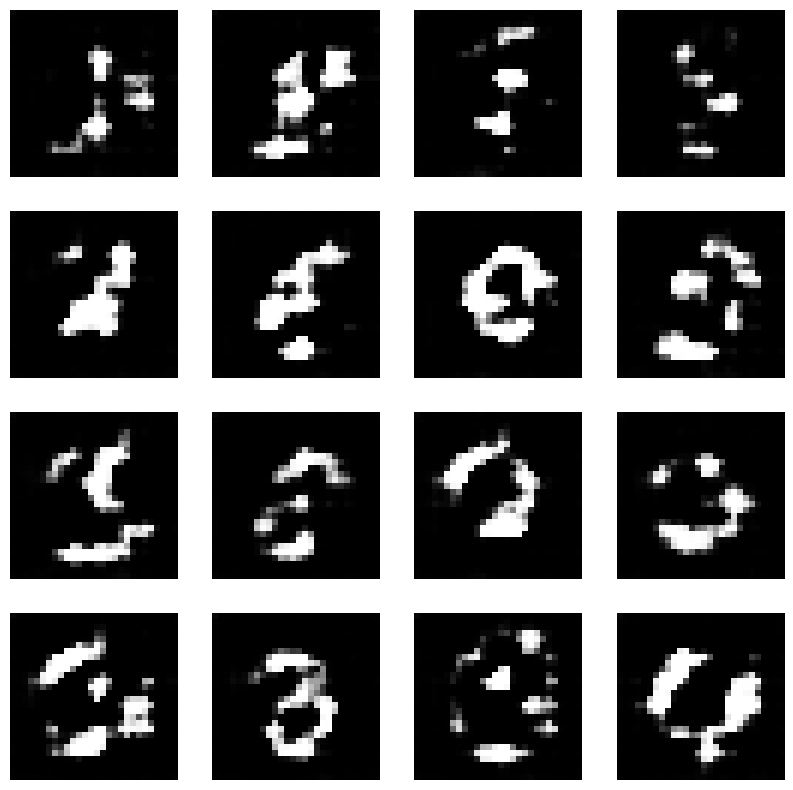

epoch = 28/100


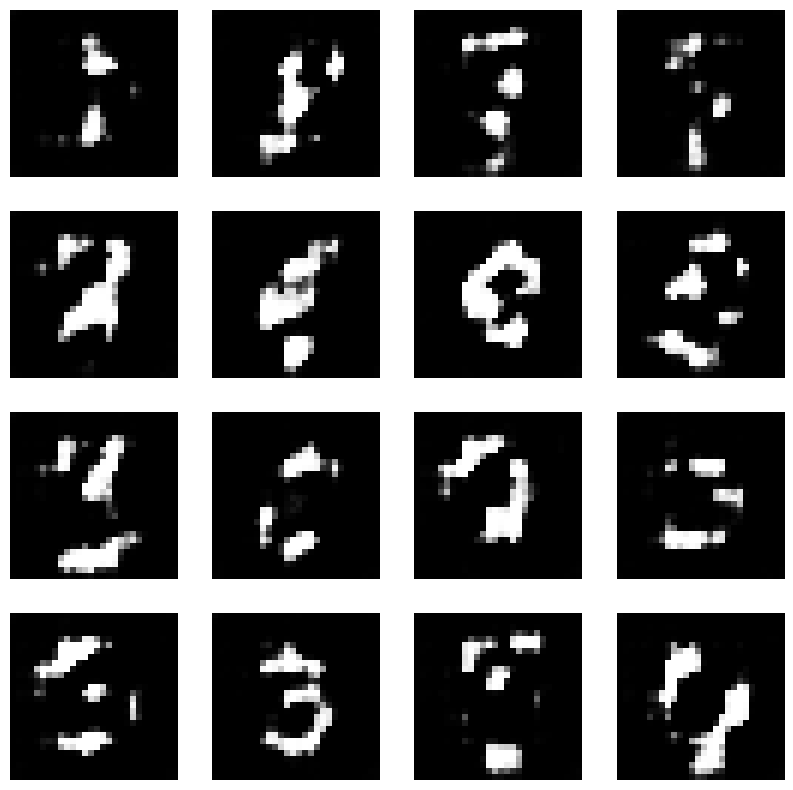

epoch = 29/100


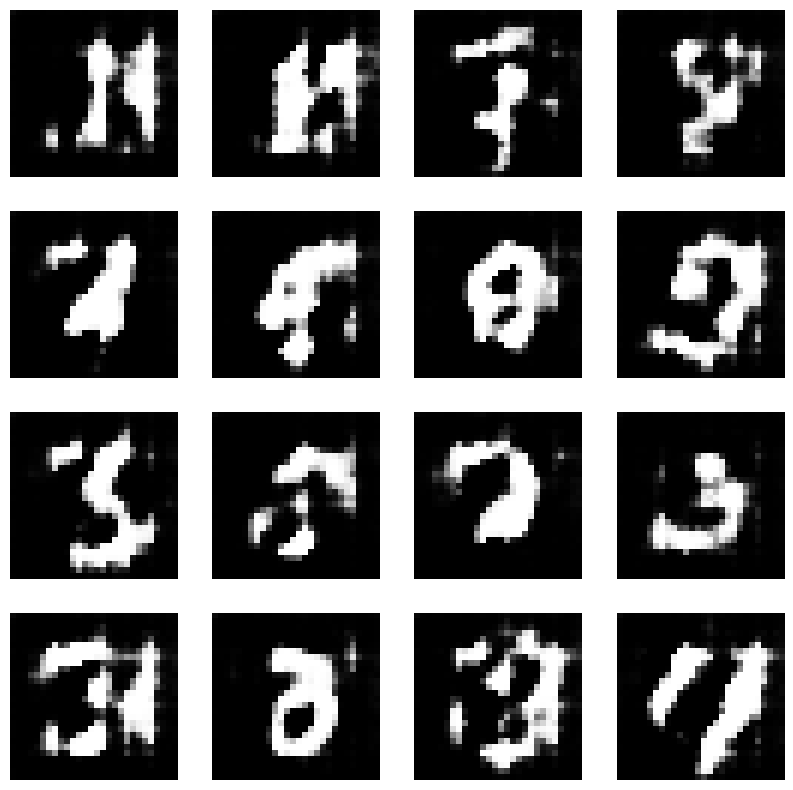

epoch = 30/100


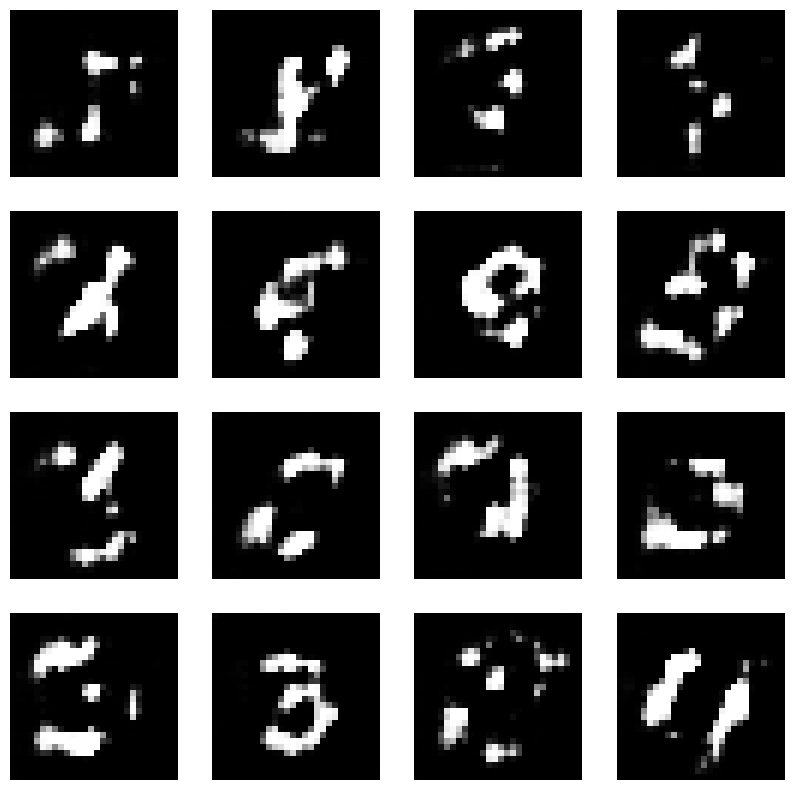

epoch = 31/100


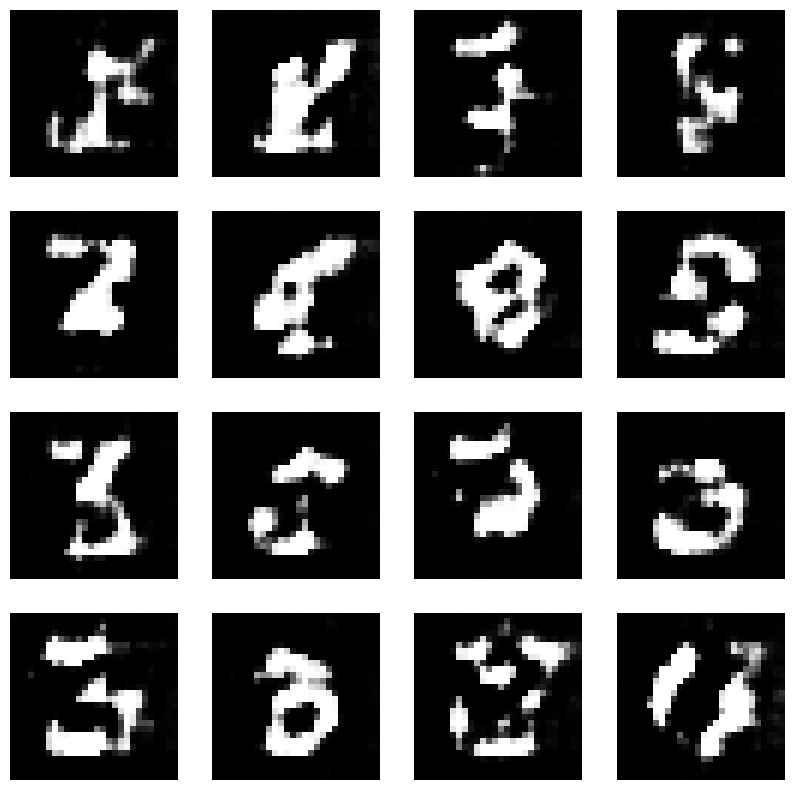

epoch = 32/100


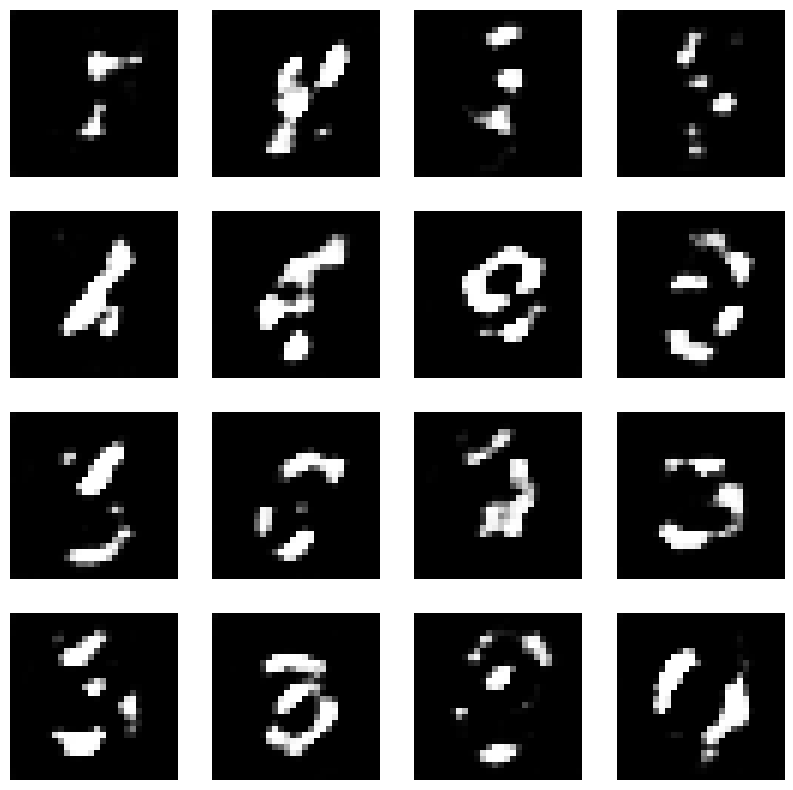

epoch = 33/100


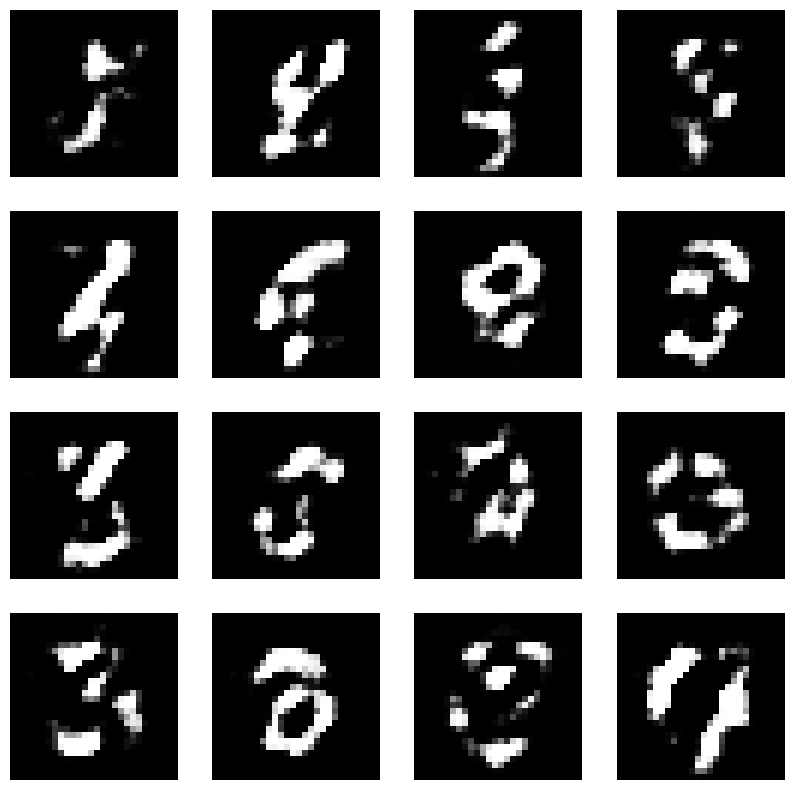

epoch = 34/100


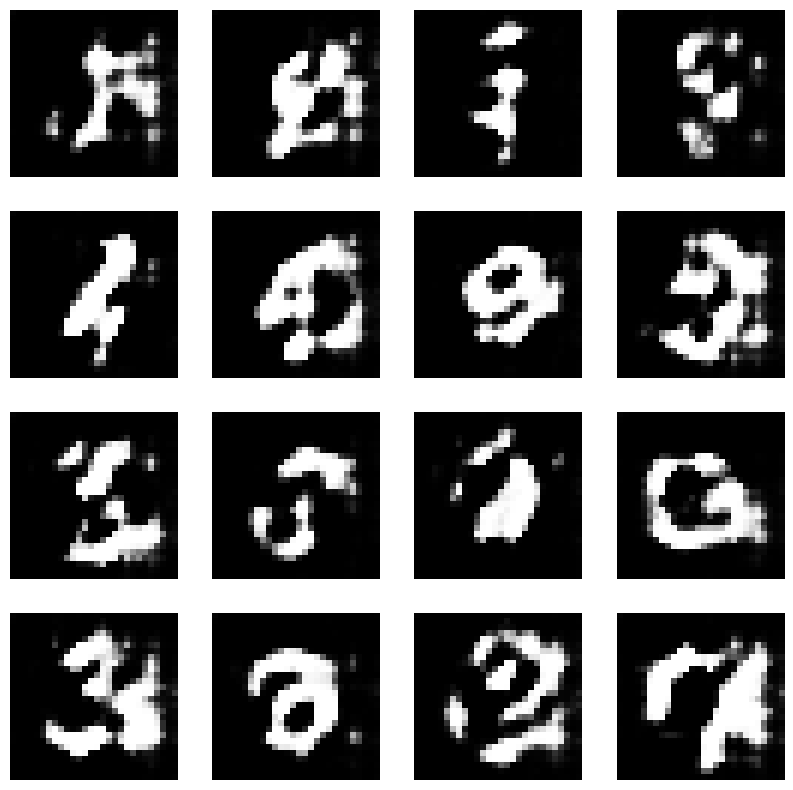

epoch = 35/100


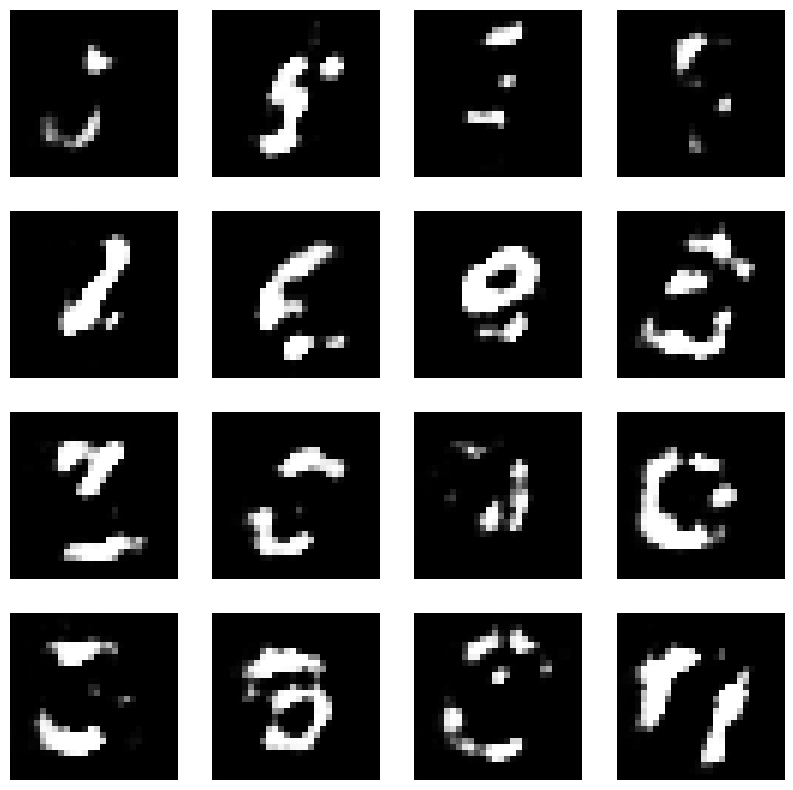

epoch = 36/100


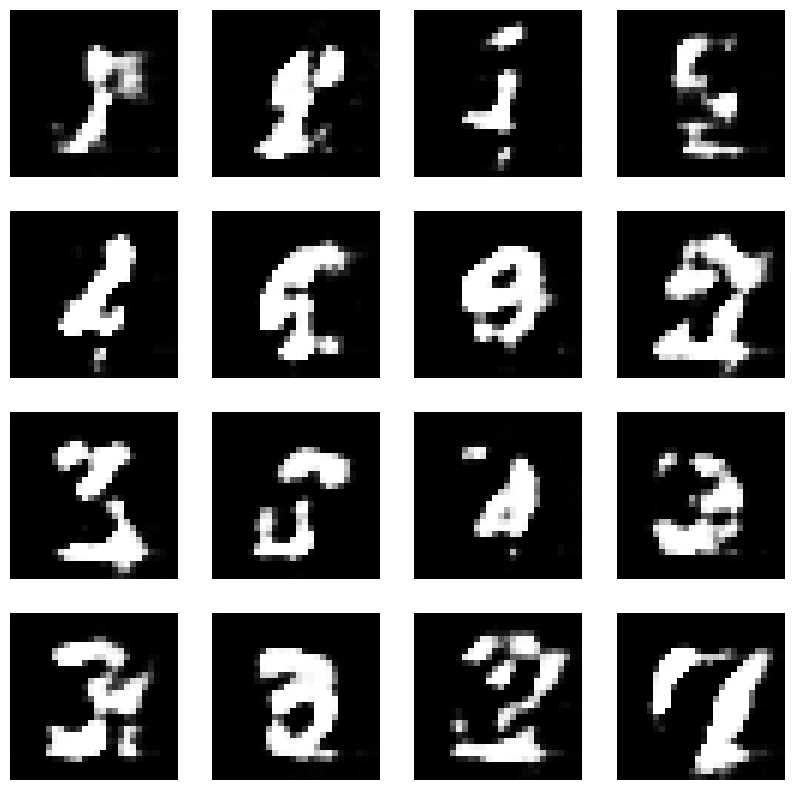

epoch = 37/100


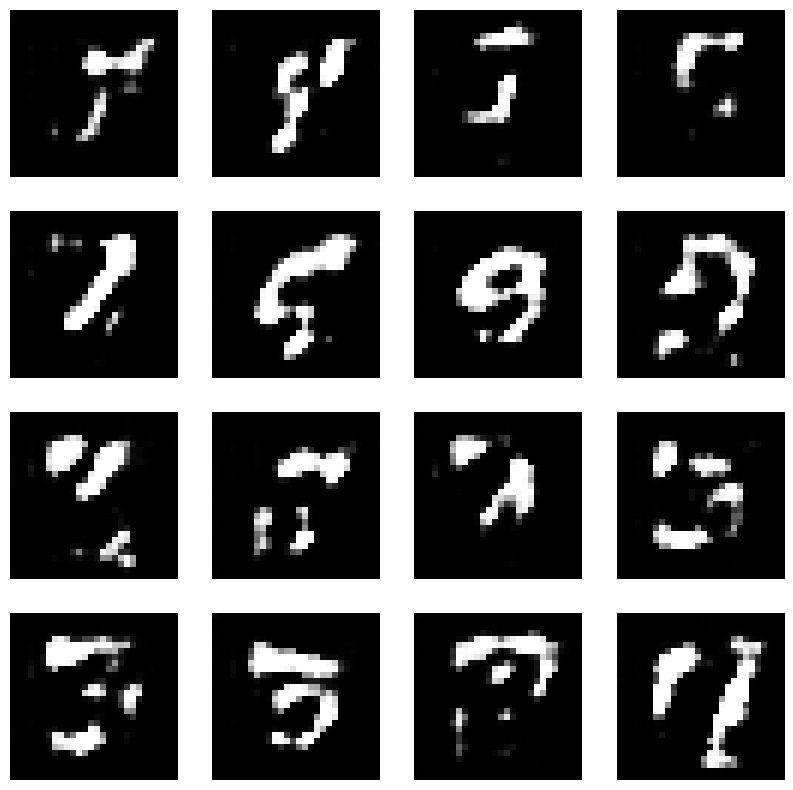

epoch = 38/100


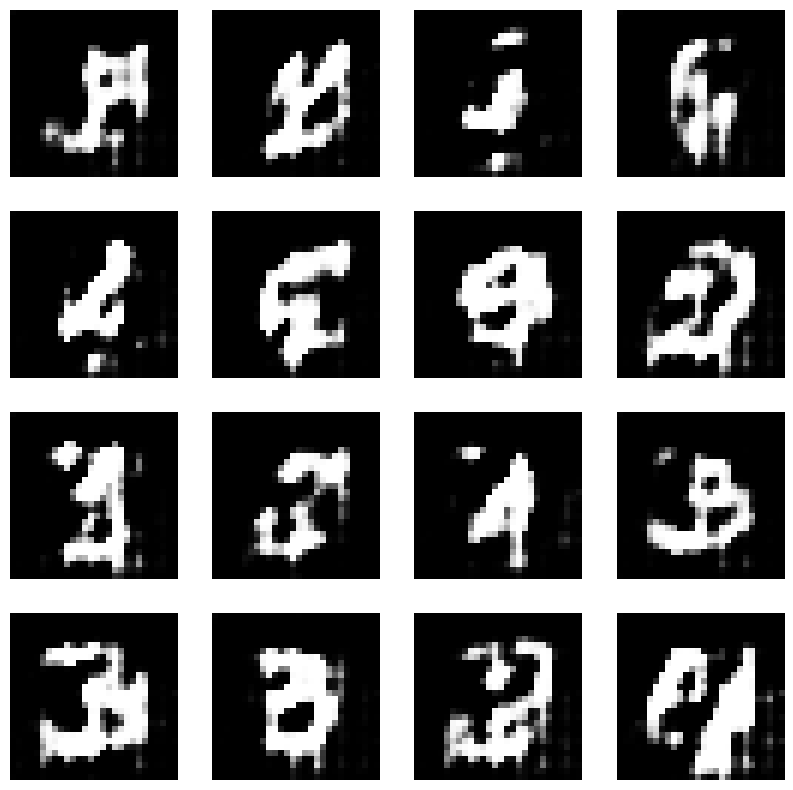

epoch = 39/100


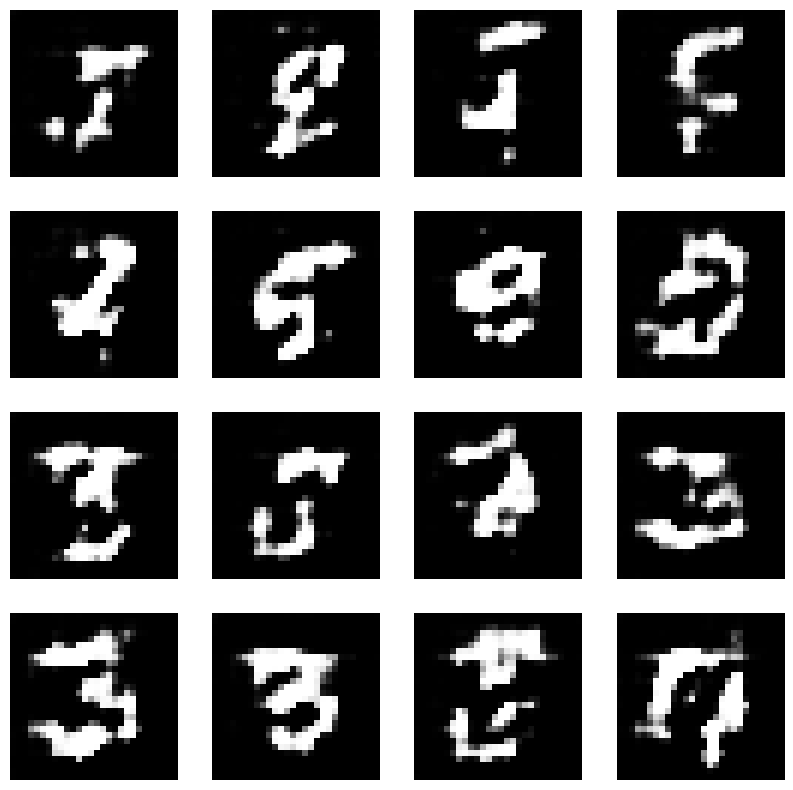

epoch = 40/100


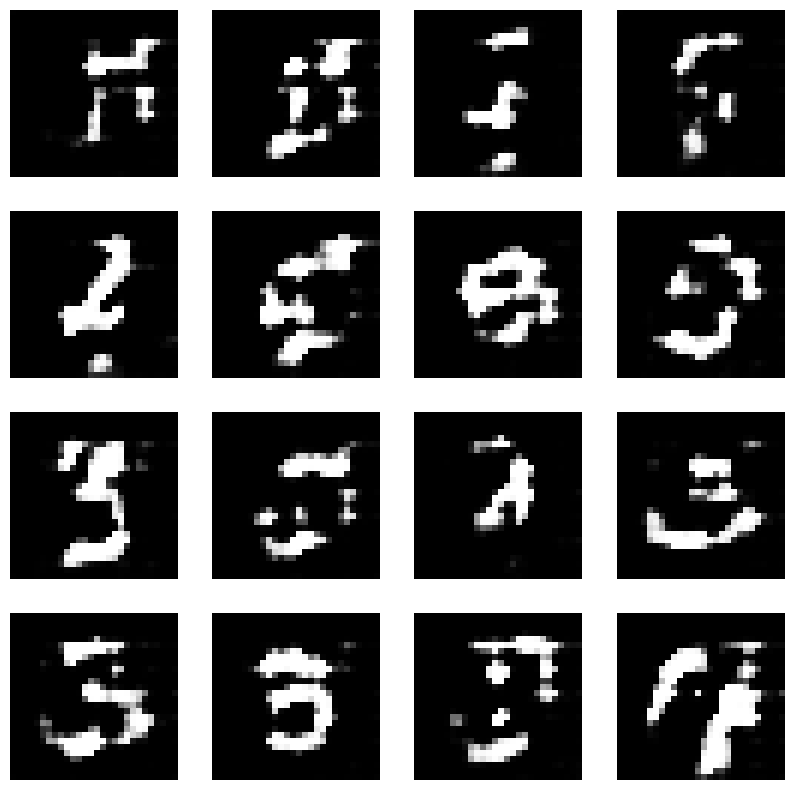

epoch = 41/100


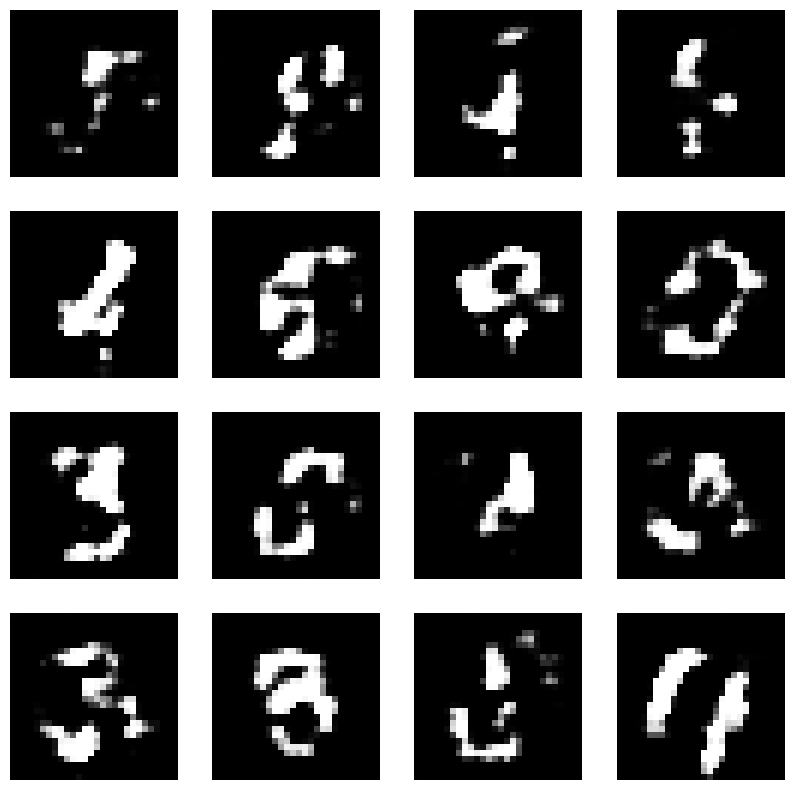

epoch = 42/100


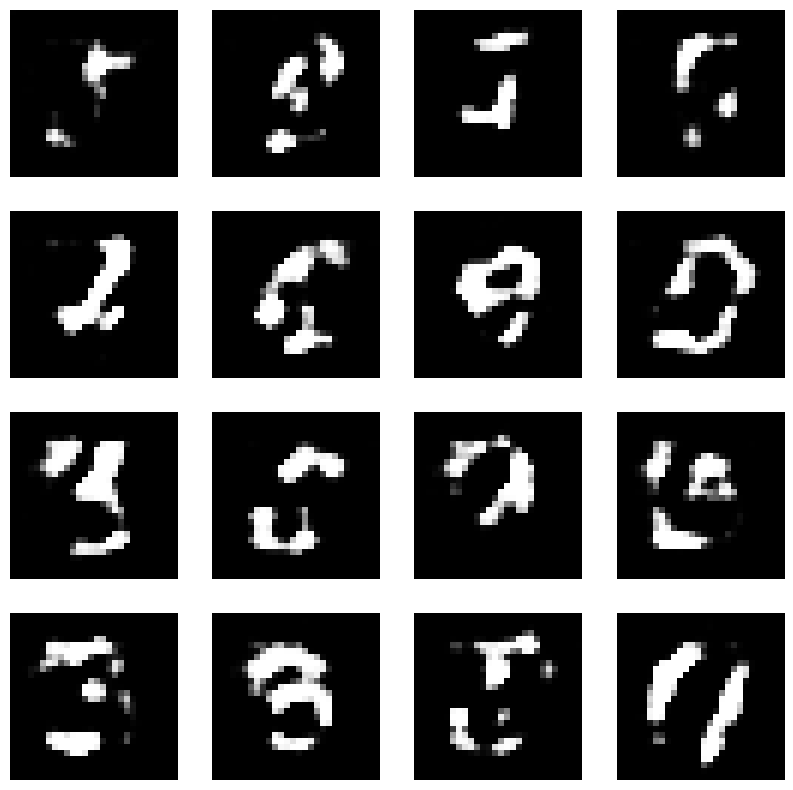

epoch = 43/100


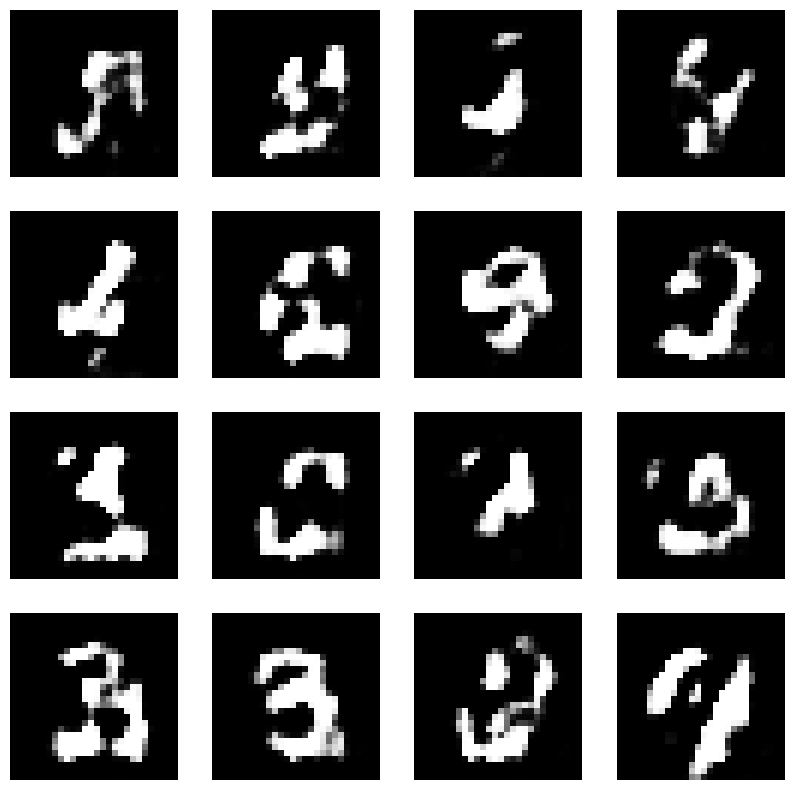

epoch = 44/100


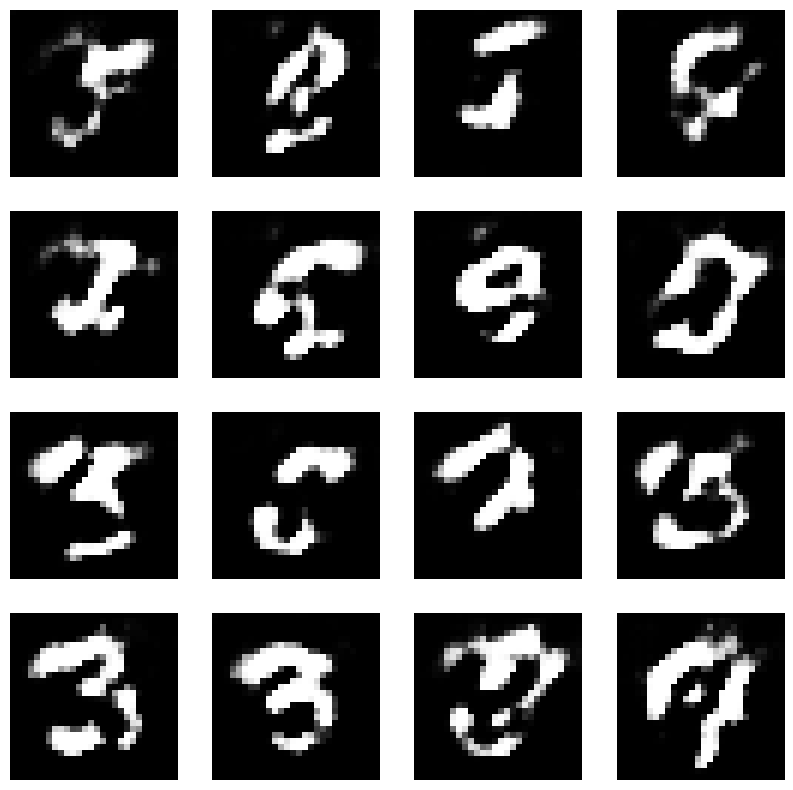

epoch = 45/100


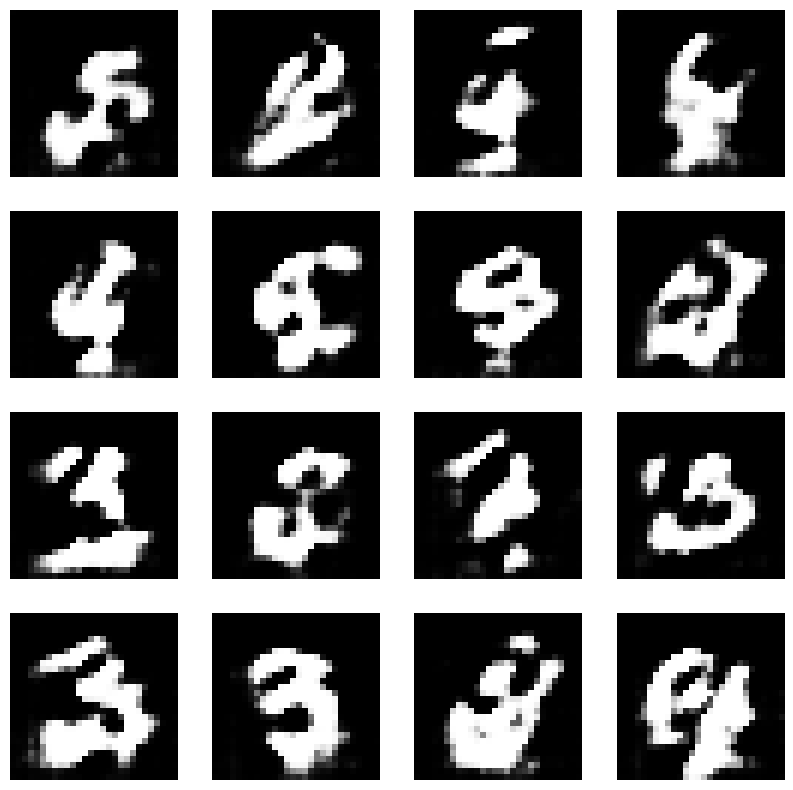

epoch = 46/100


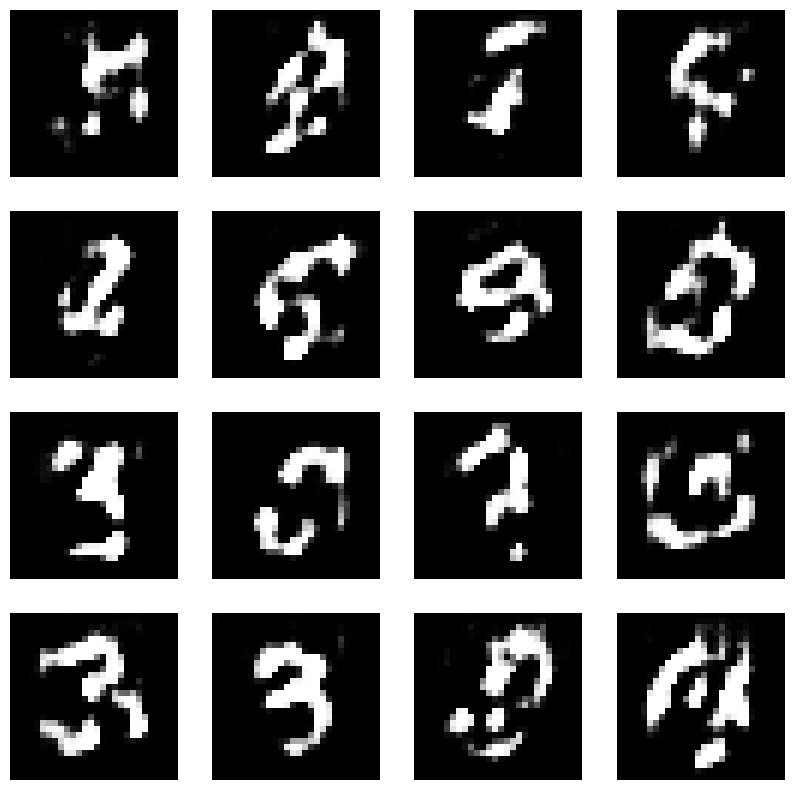

epoch = 47/100


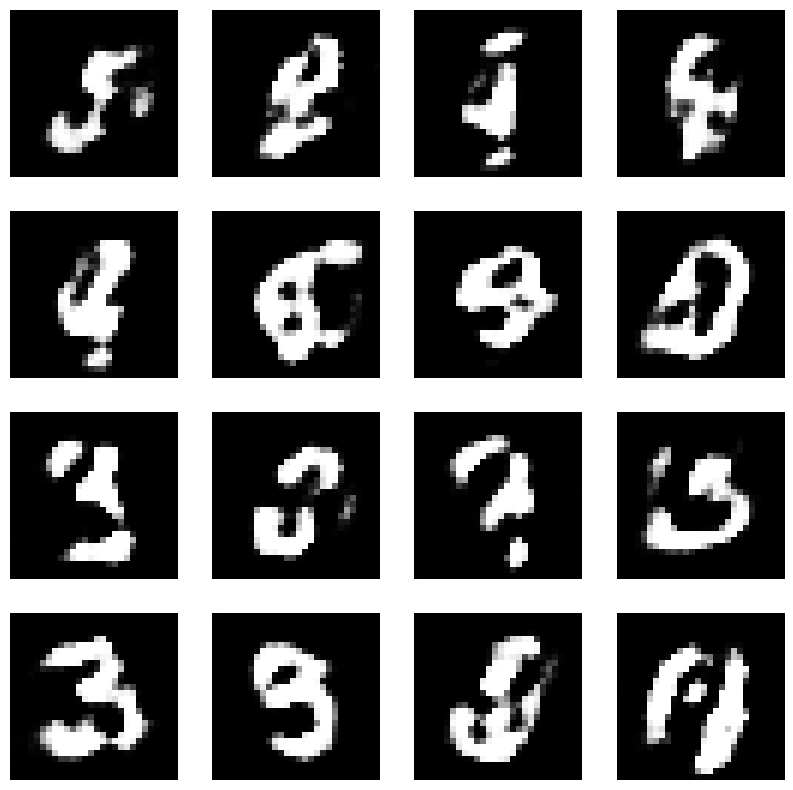

epoch = 48/100


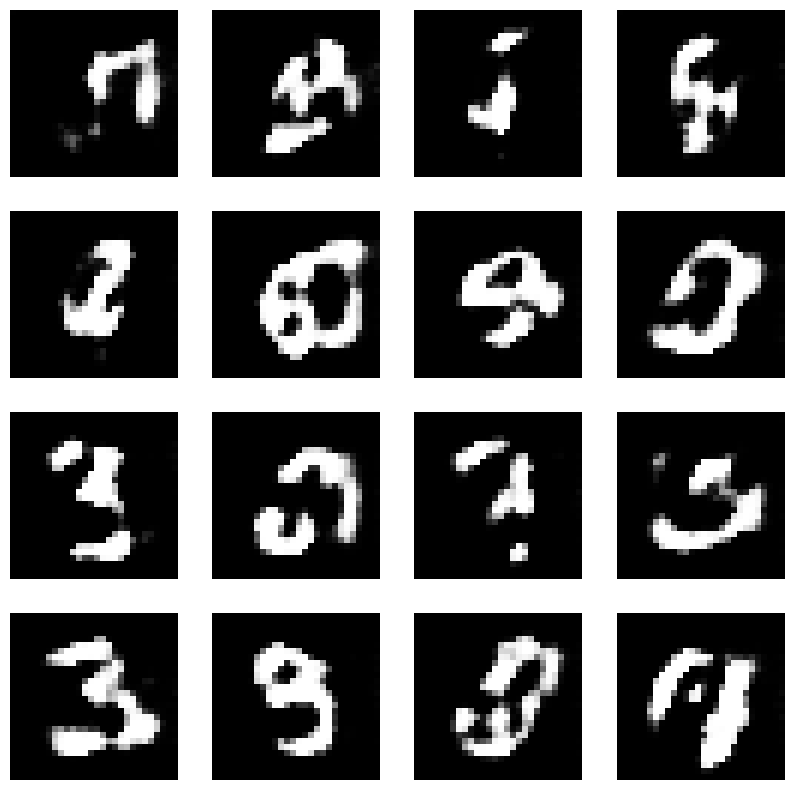

epoch = 49/100


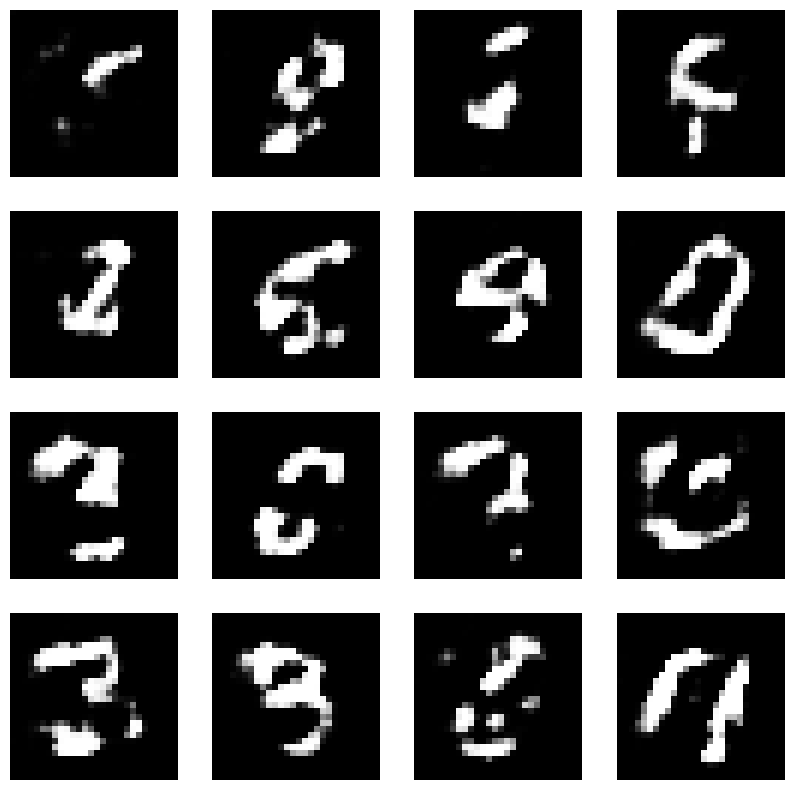

epoch = 50/100


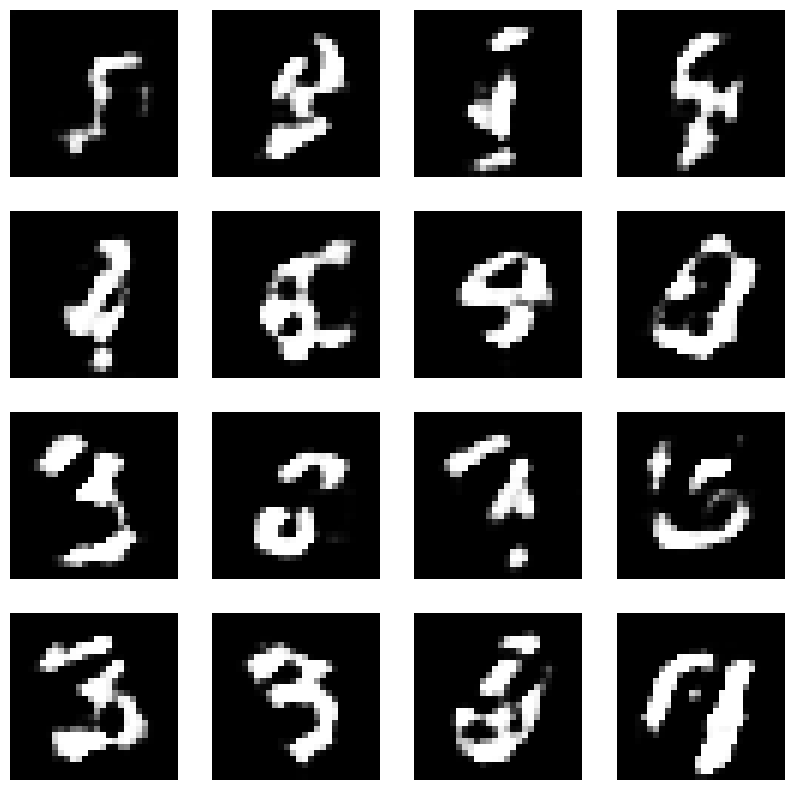

epoch = 51/100


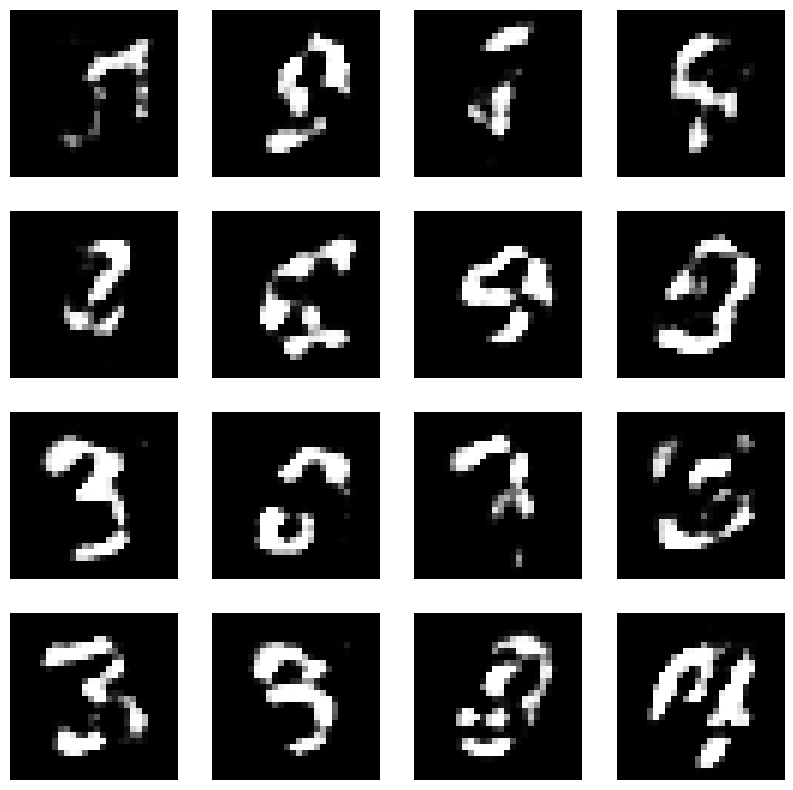

epoch = 52/100


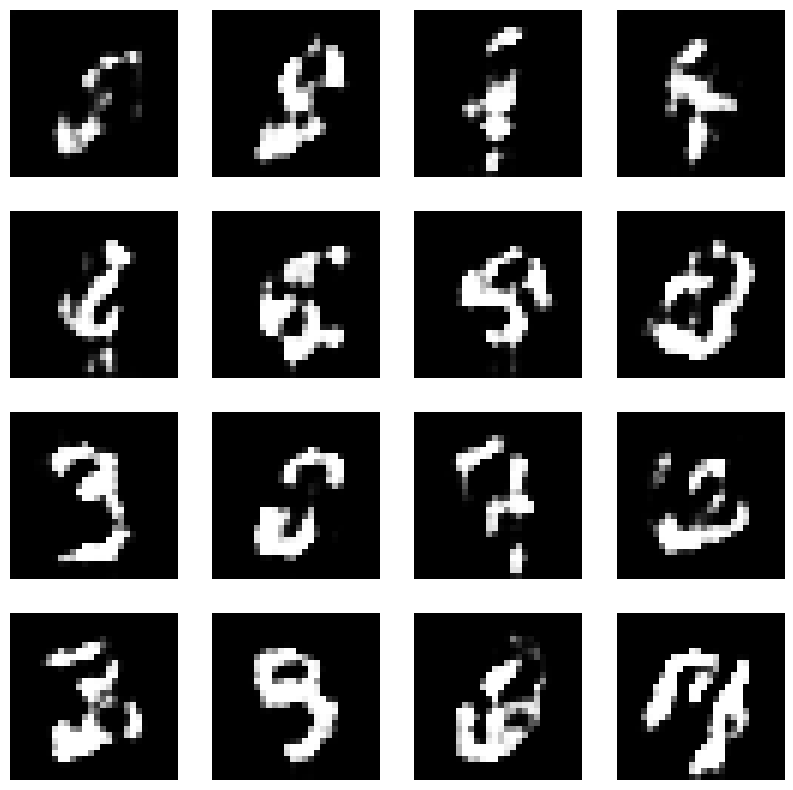

epoch = 53/100


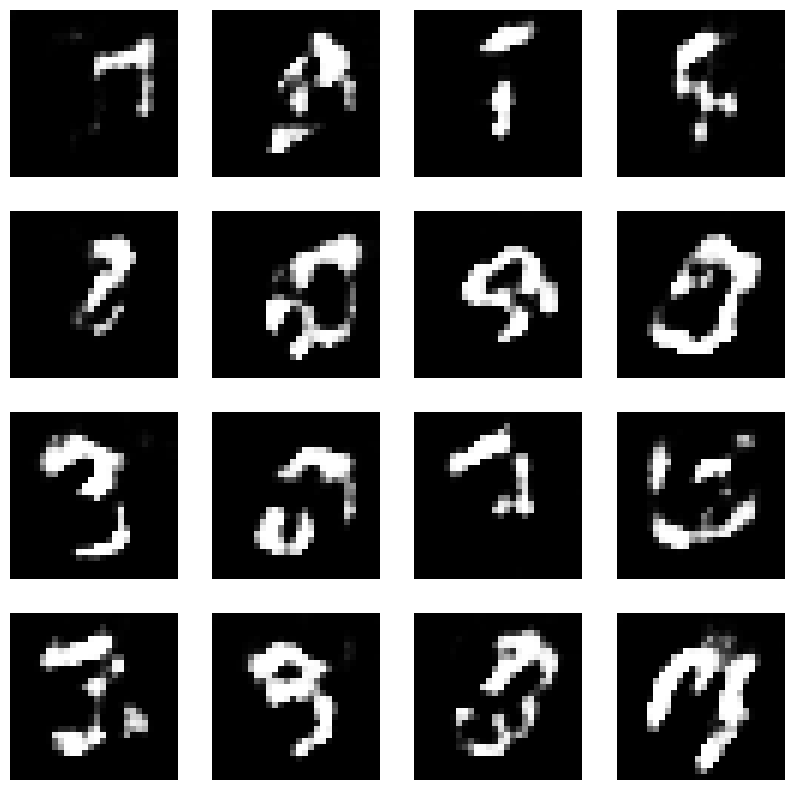

epoch = 54/100


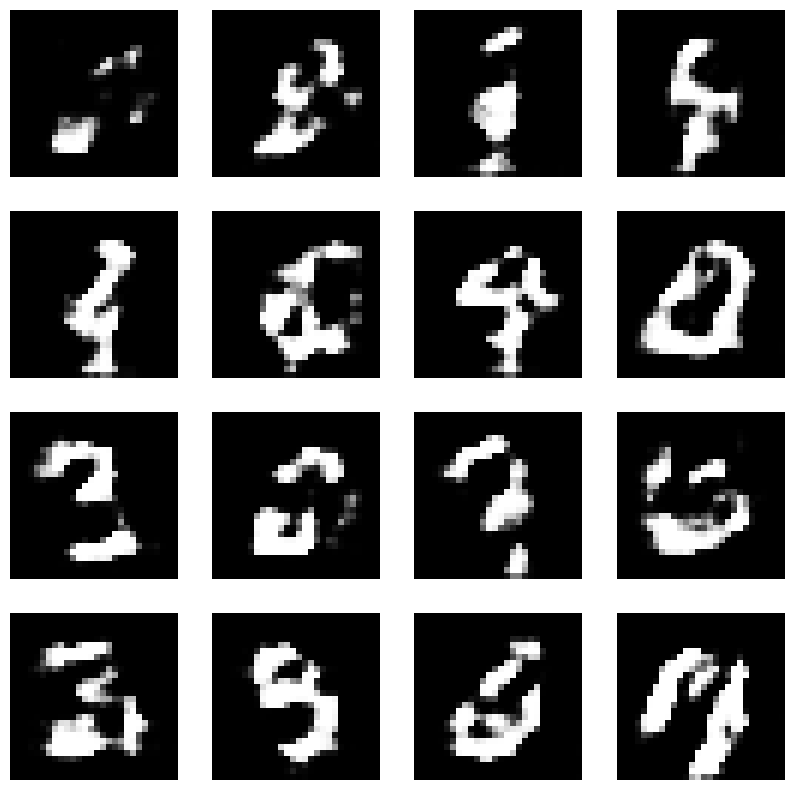

epoch = 55/100


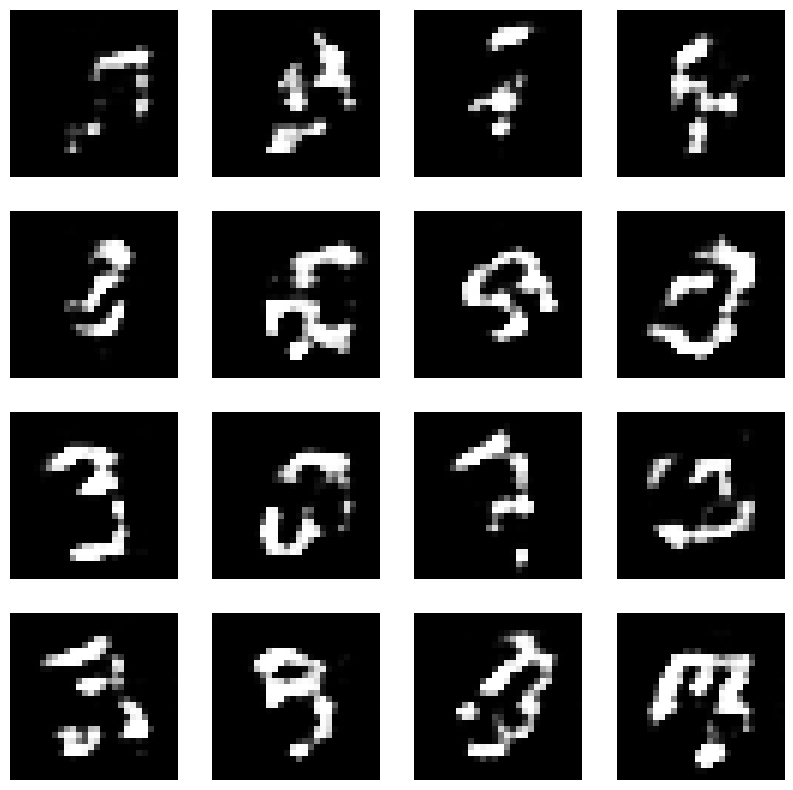

epoch = 56/100


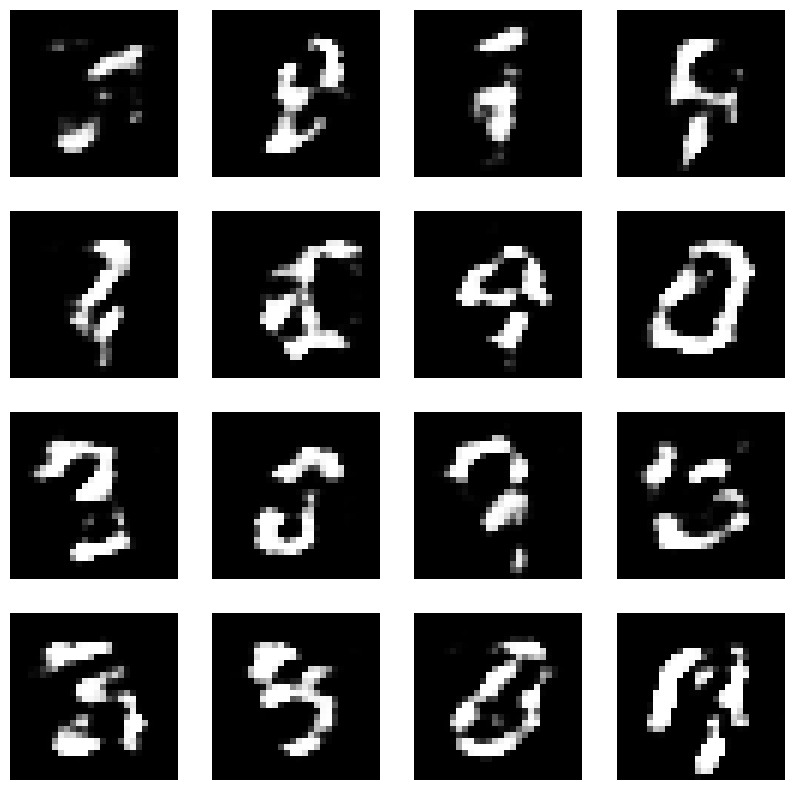

epoch = 57/100


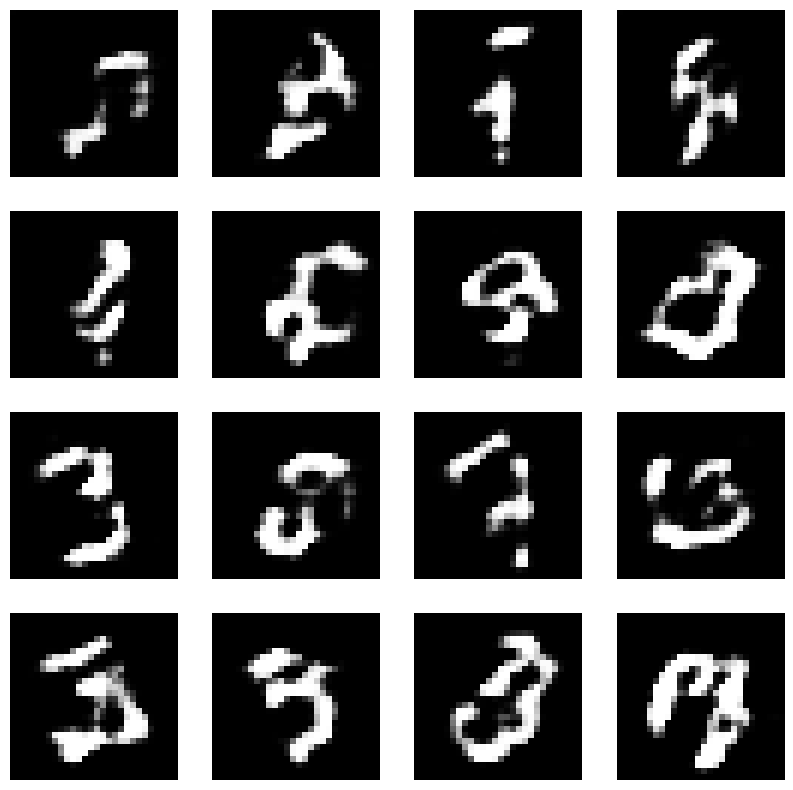

epoch = 58/100


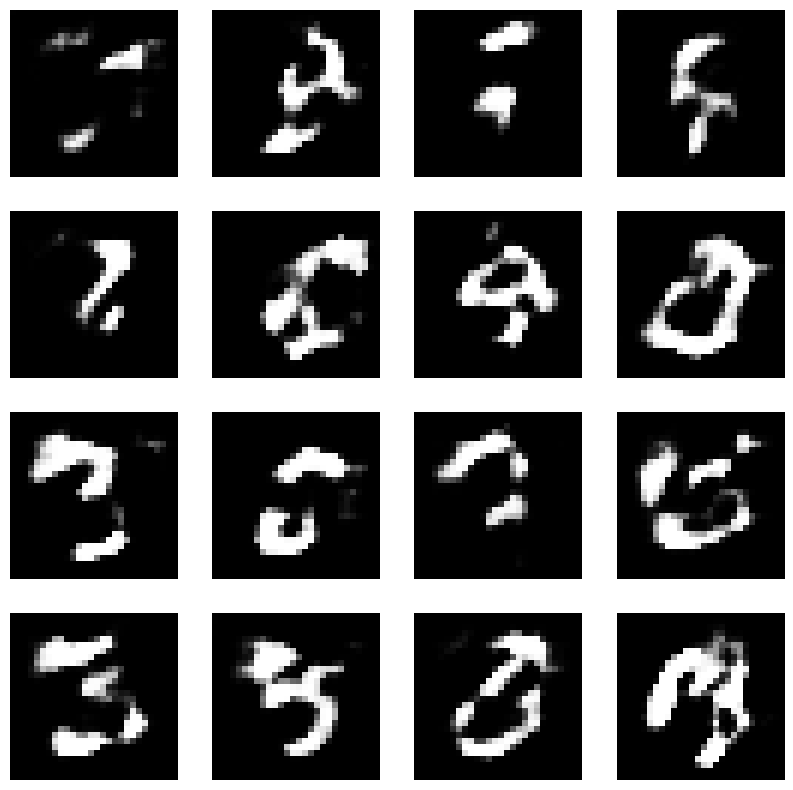

epoch = 59/100


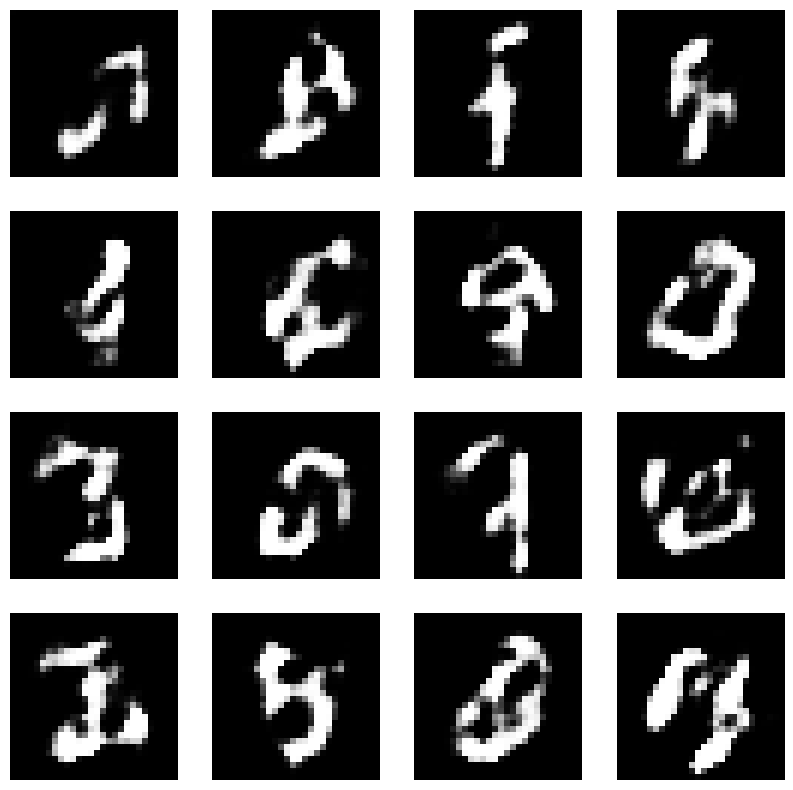

epoch = 60/100


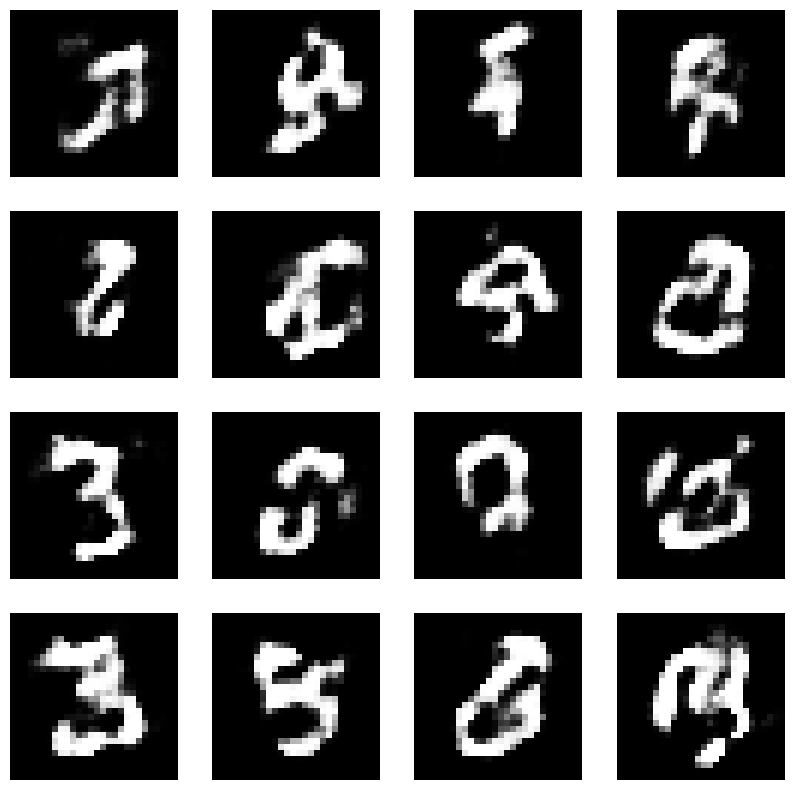

epoch = 61/100


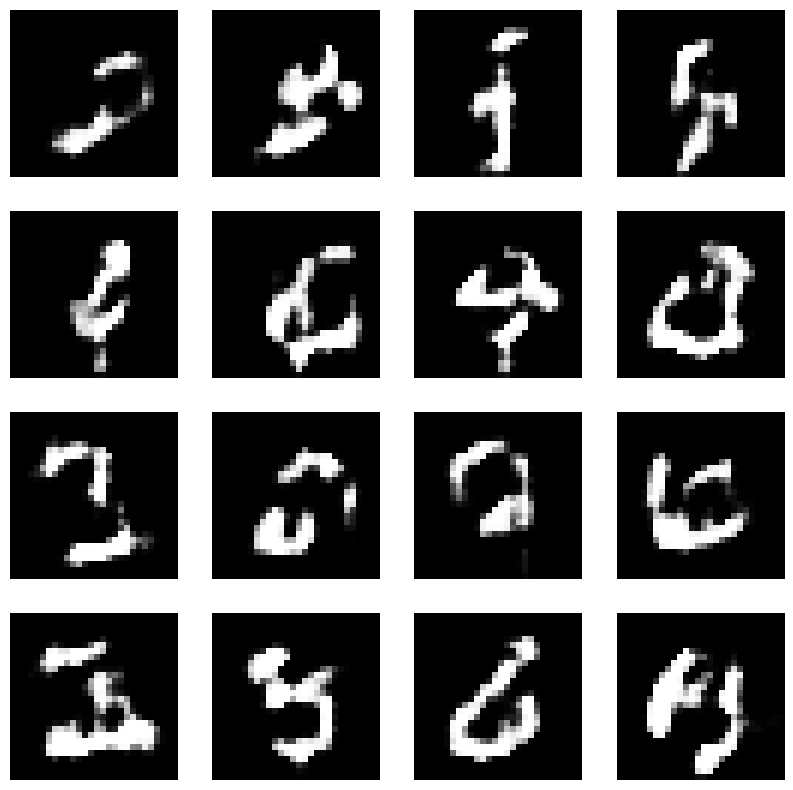

epoch = 62/100


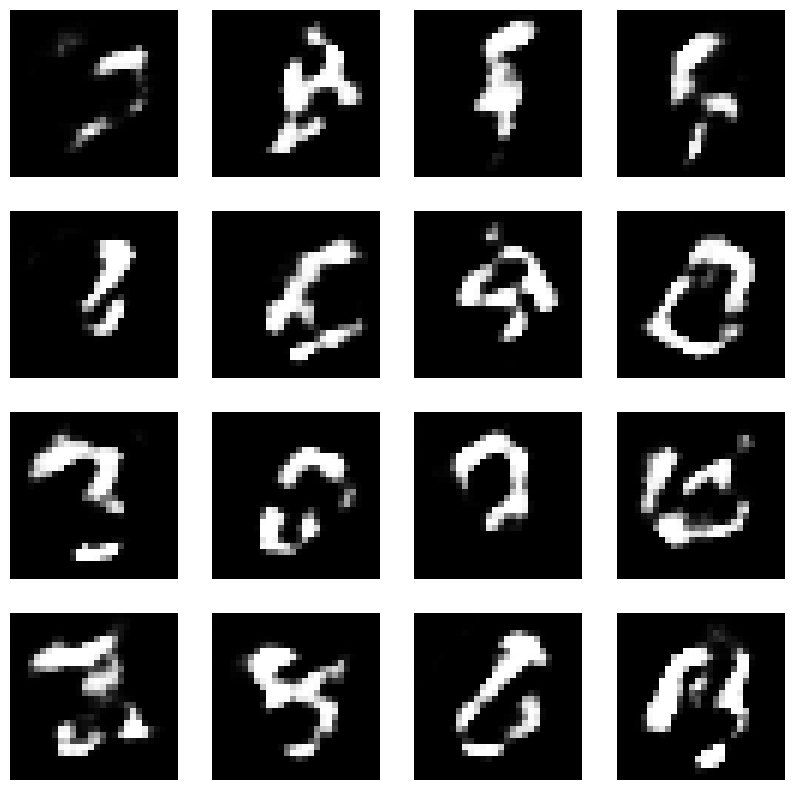

epoch = 63/100


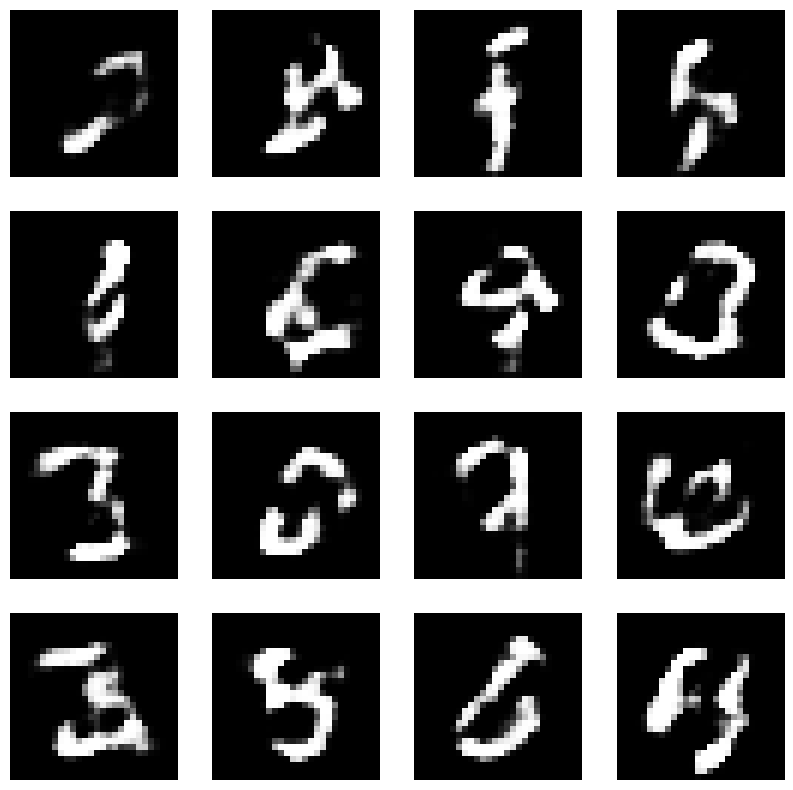

epoch = 64/100


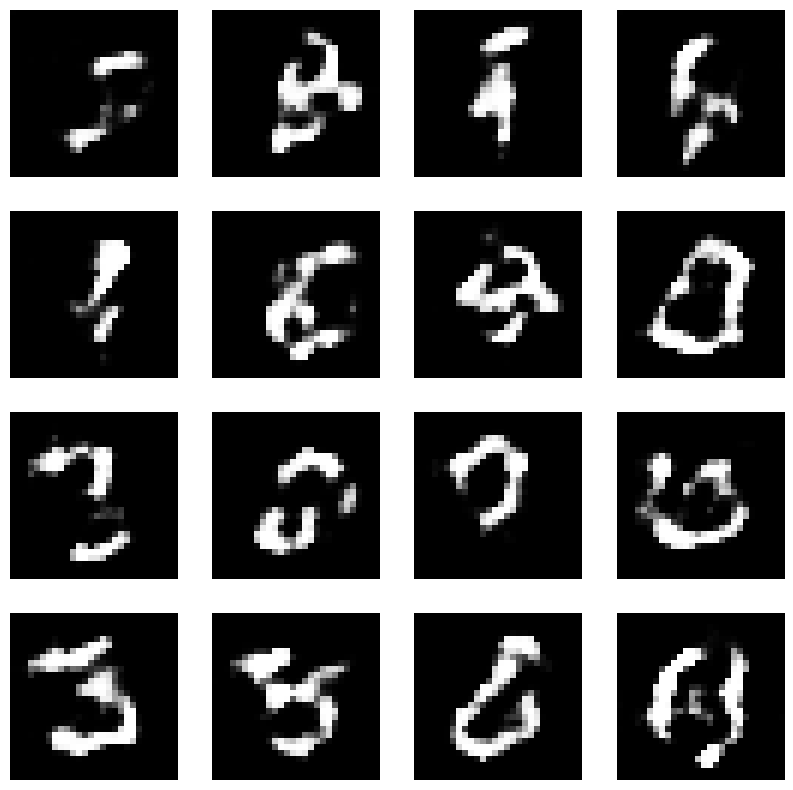

epoch = 65/100


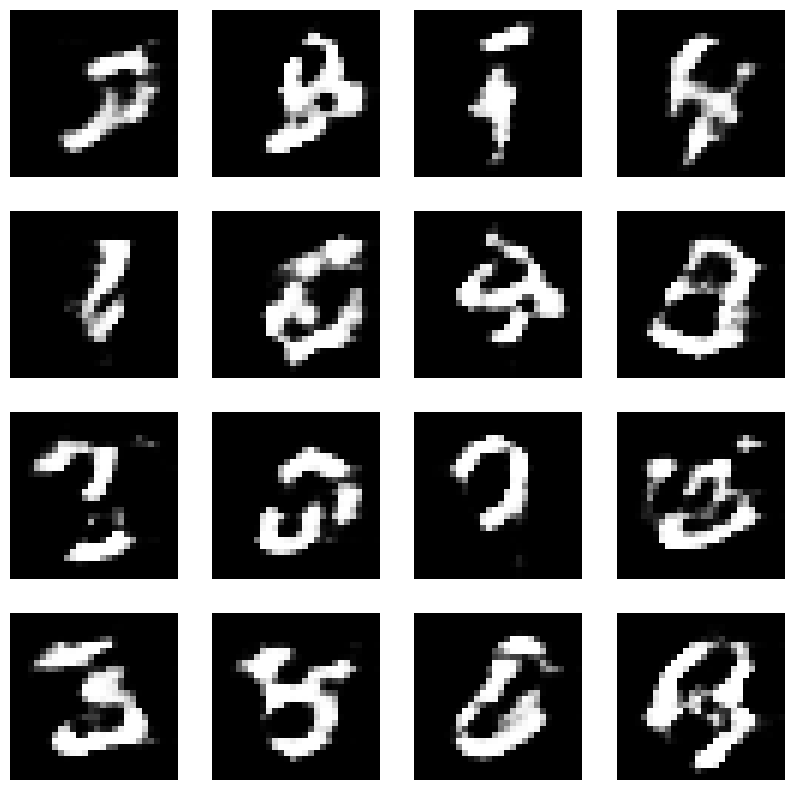

epoch = 66/100


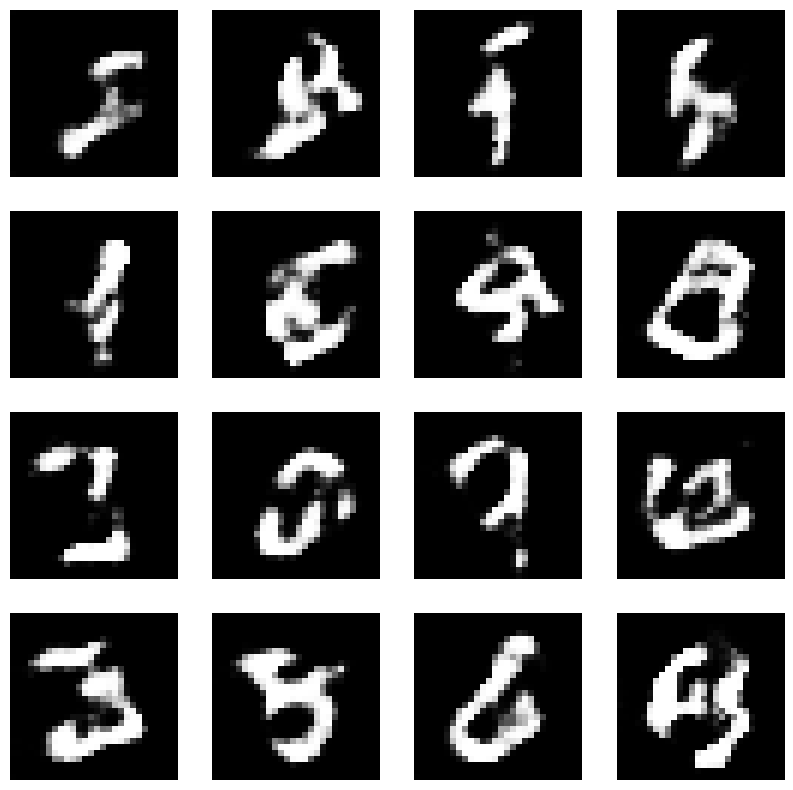

epoch = 67/100


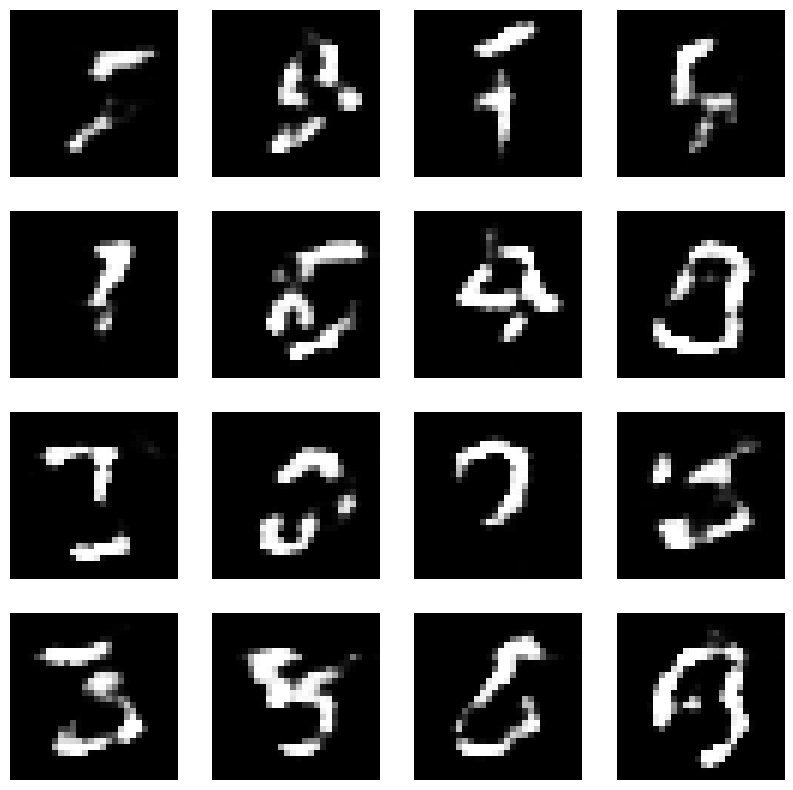

epoch = 68/100


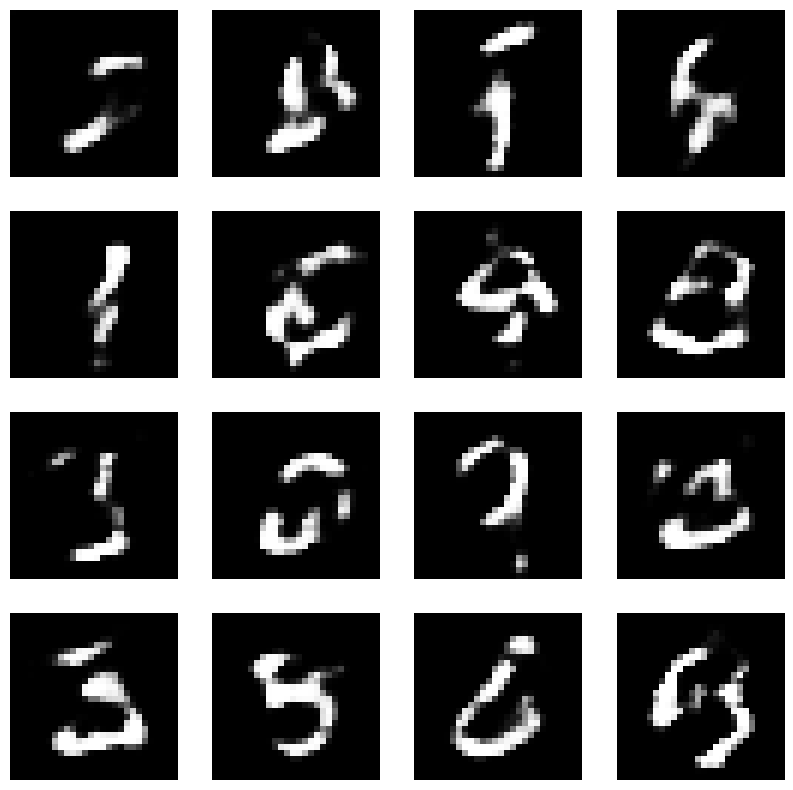

epoch = 69/100


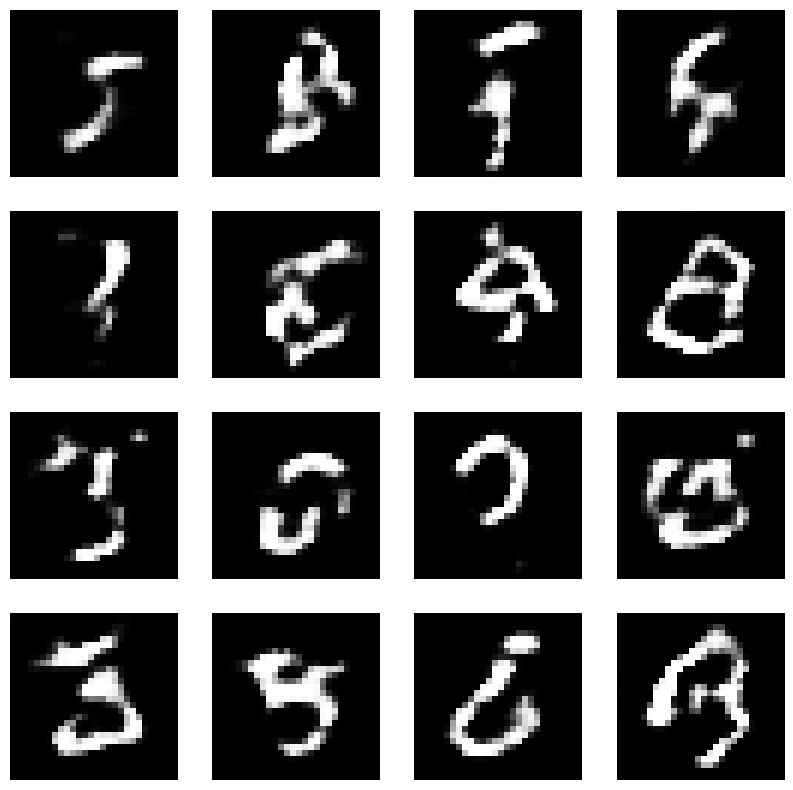

epoch = 70/100


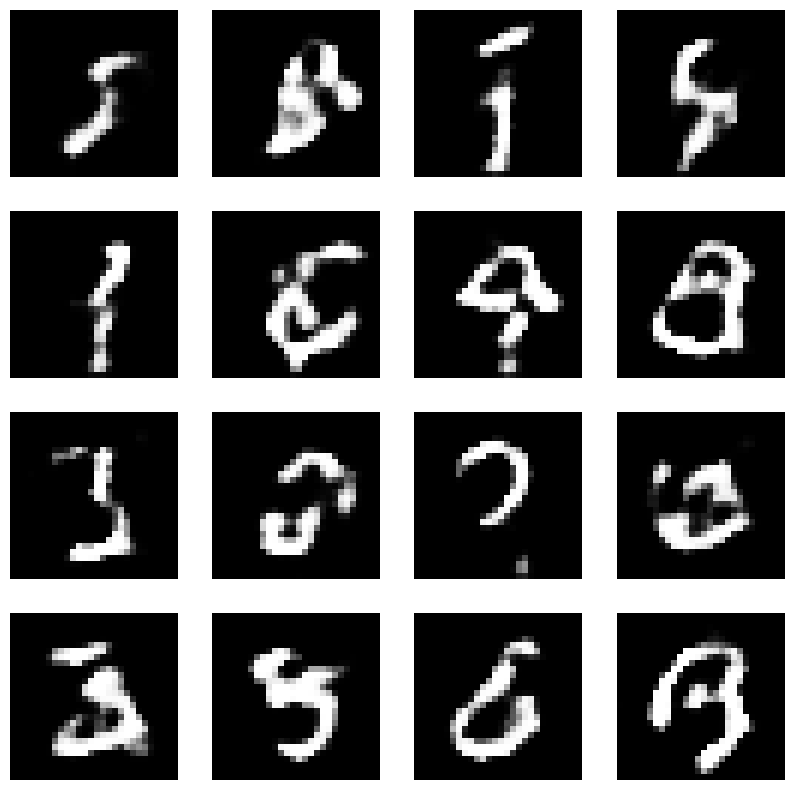

epoch = 71/100


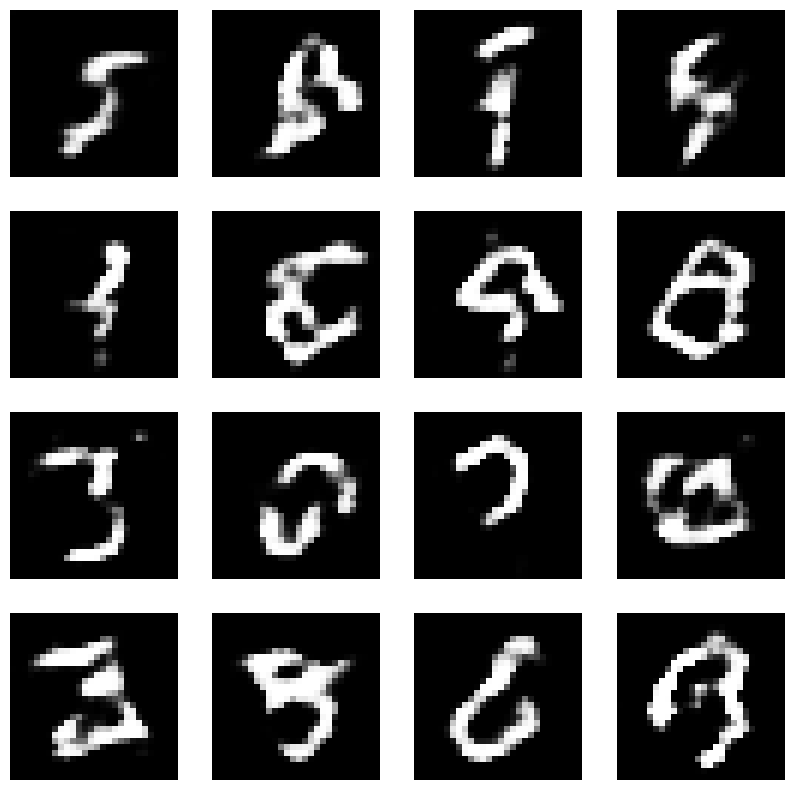

epoch = 72/100


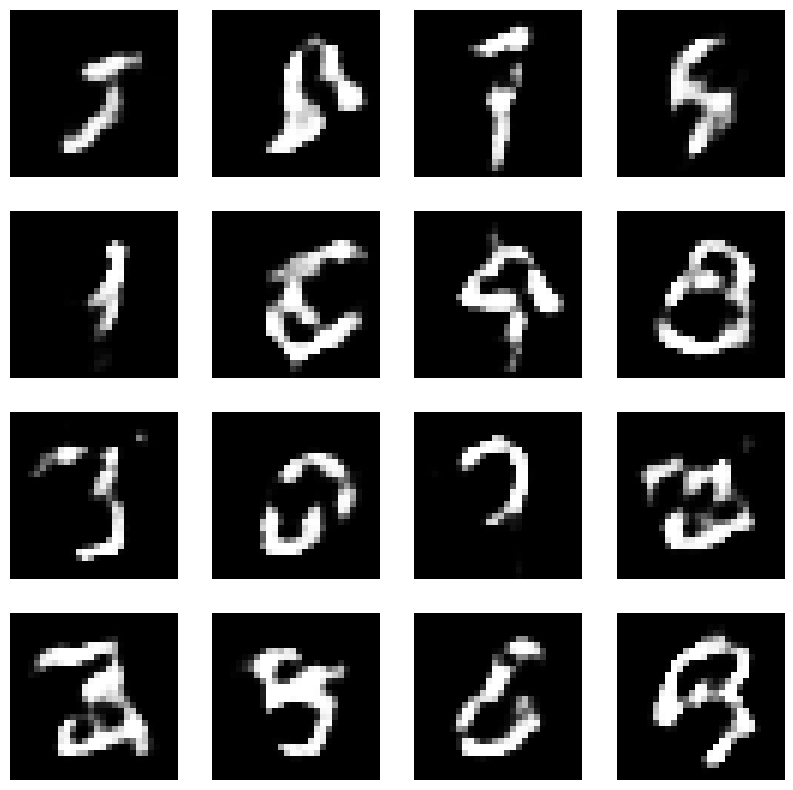

epoch = 73/100


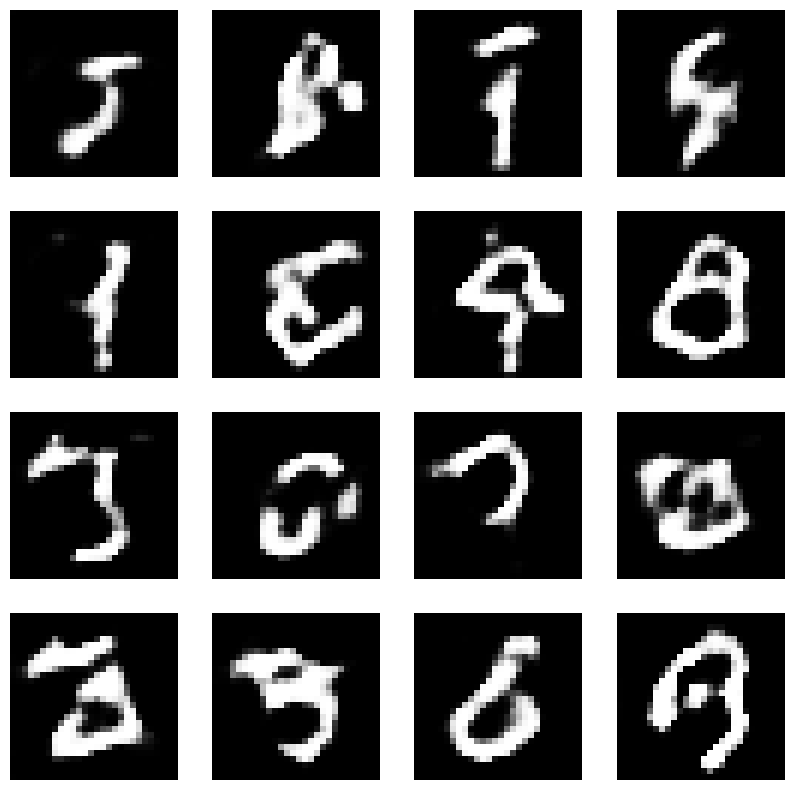

epoch = 74/100


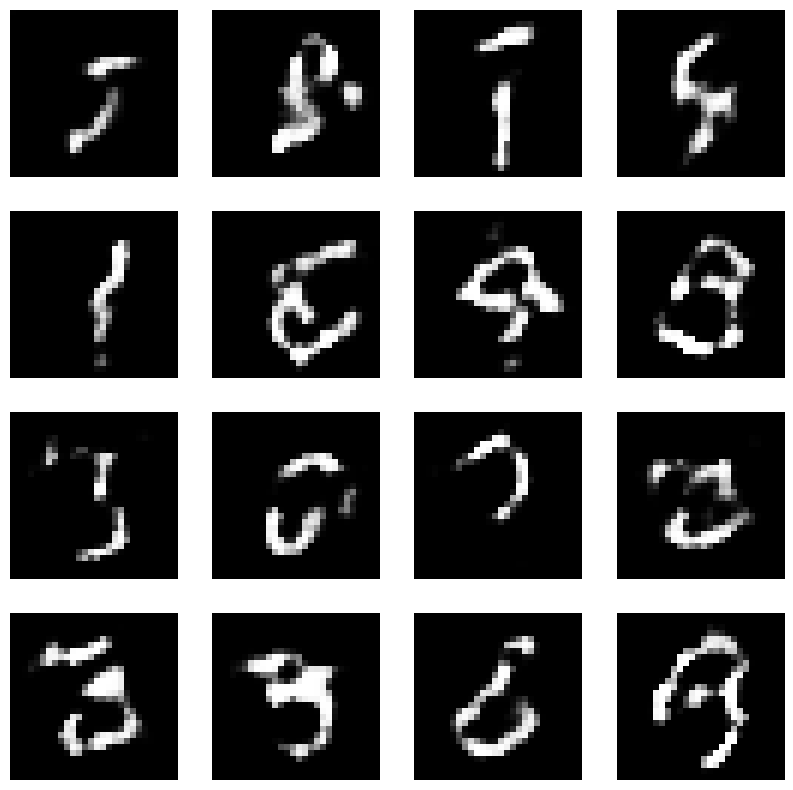

epoch = 75/100


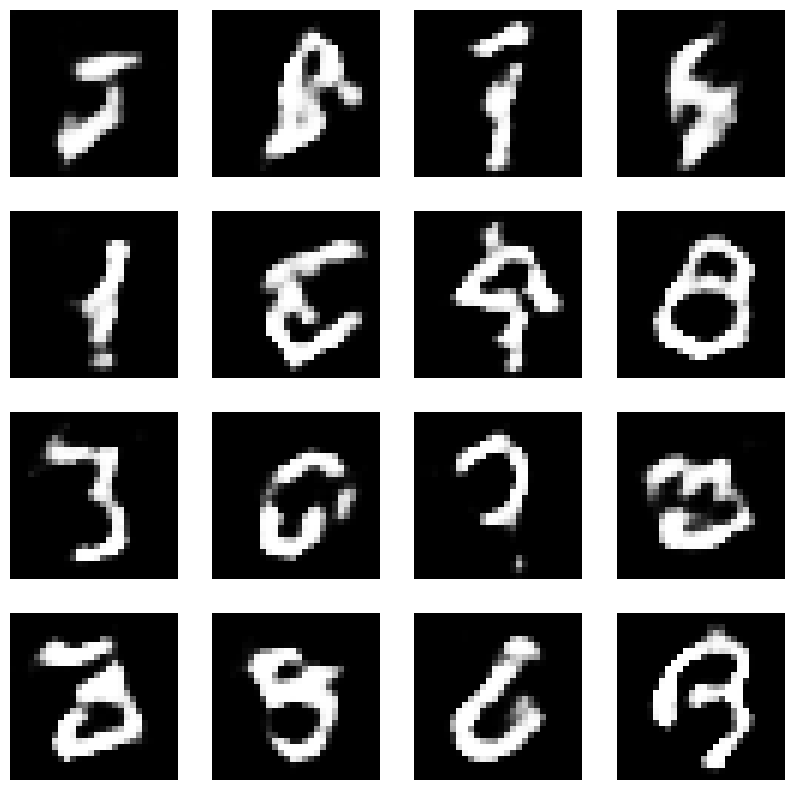

epoch = 76/100


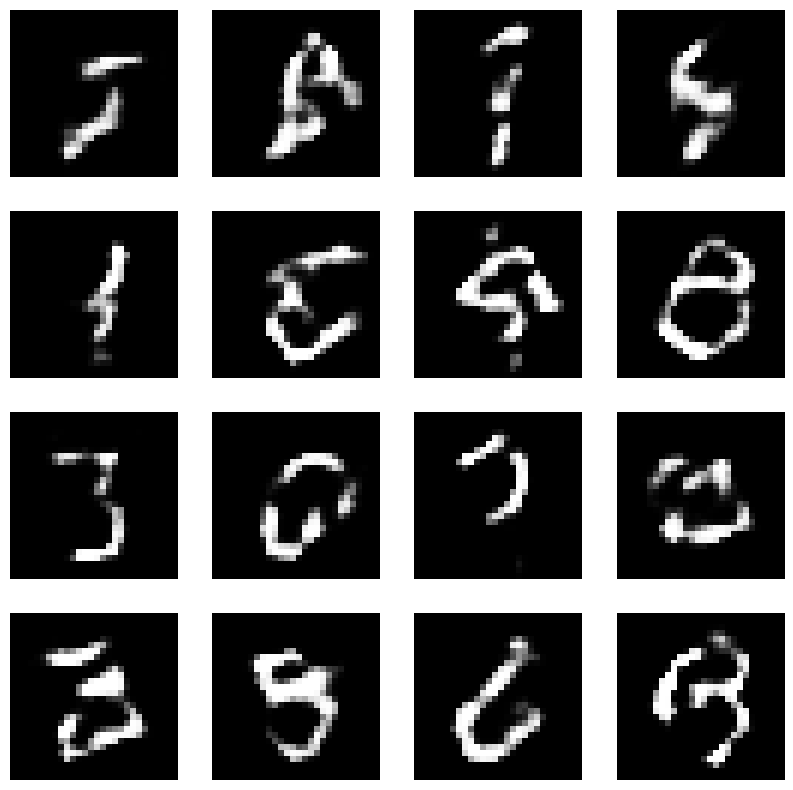

epoch = 77/100


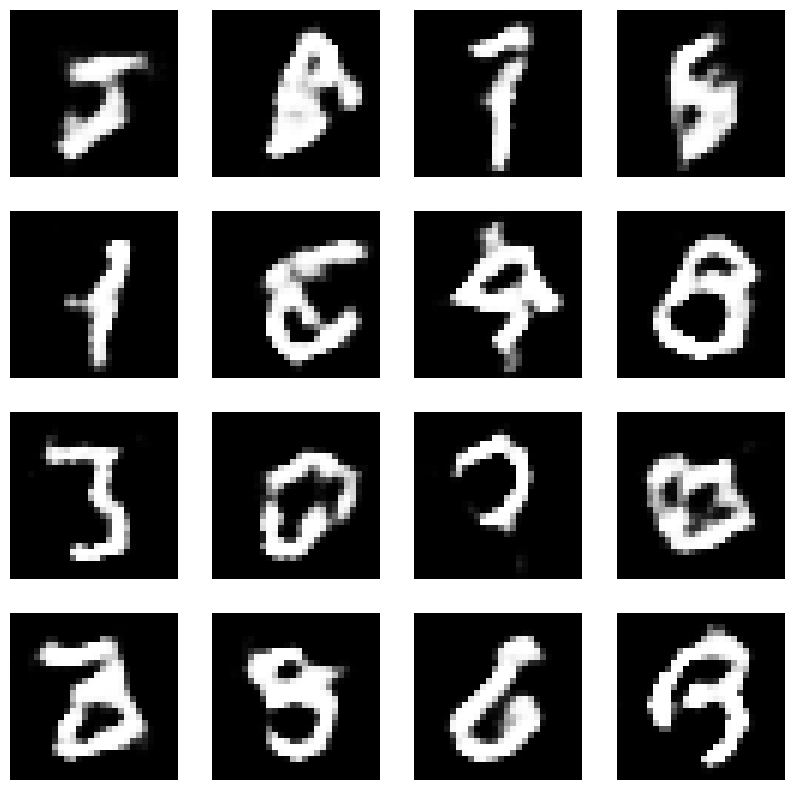

epoch = 78/100


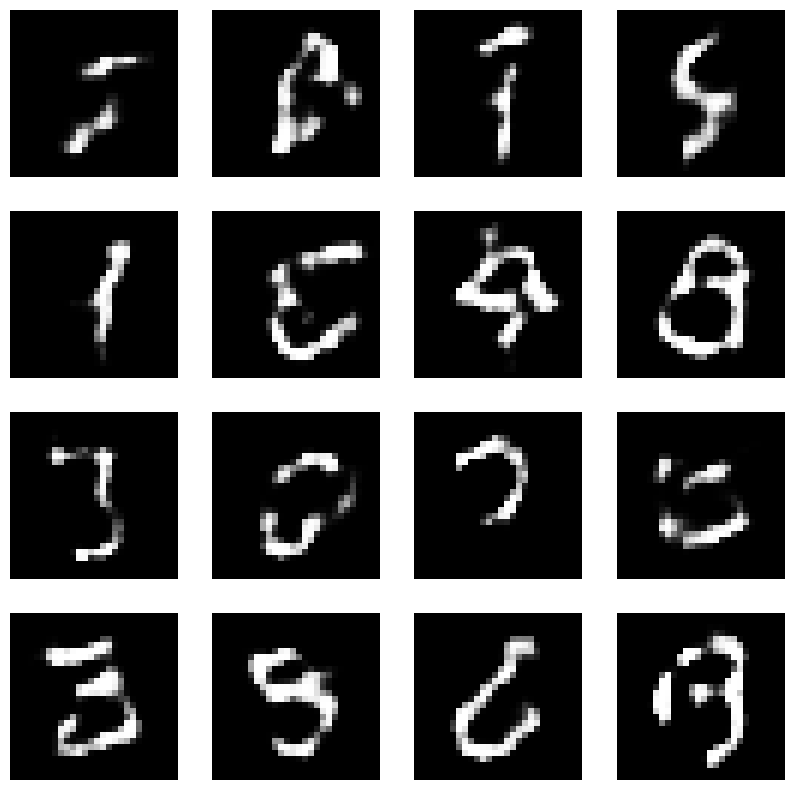

epoch = 79/100


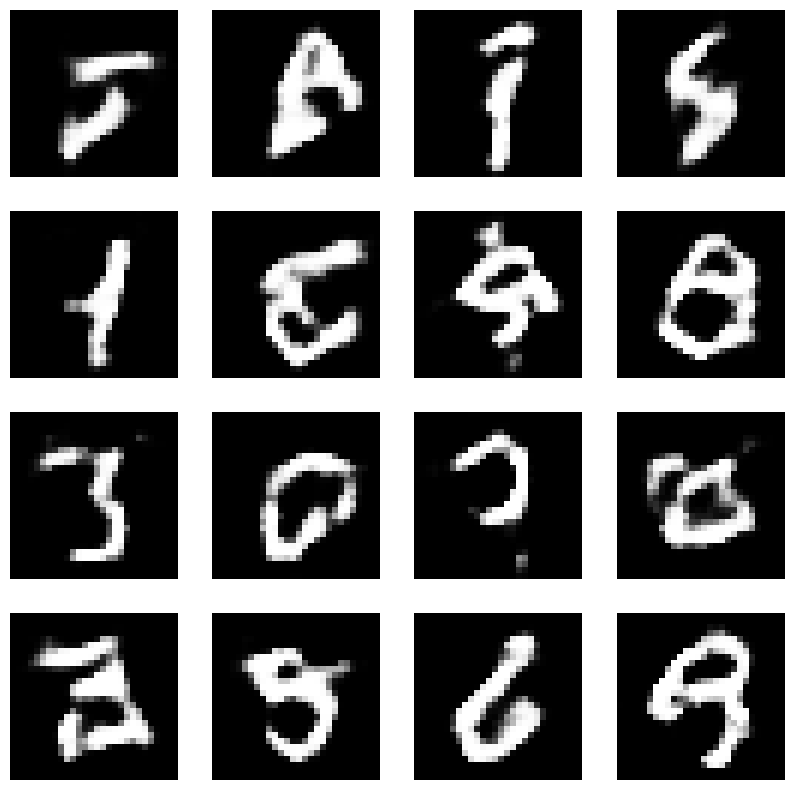

epoch = 80/100


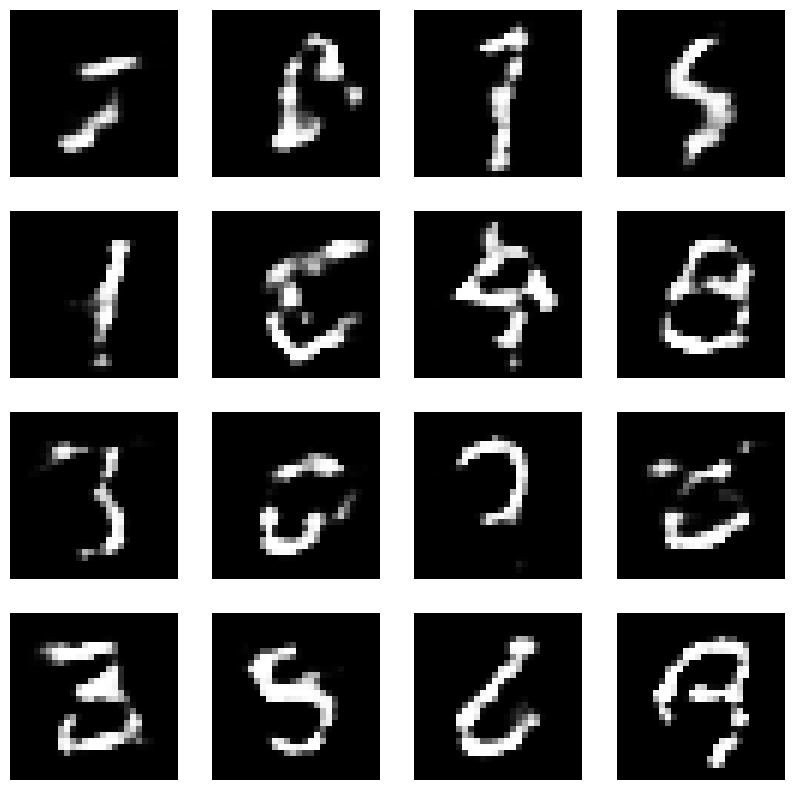

epoch = 81/100


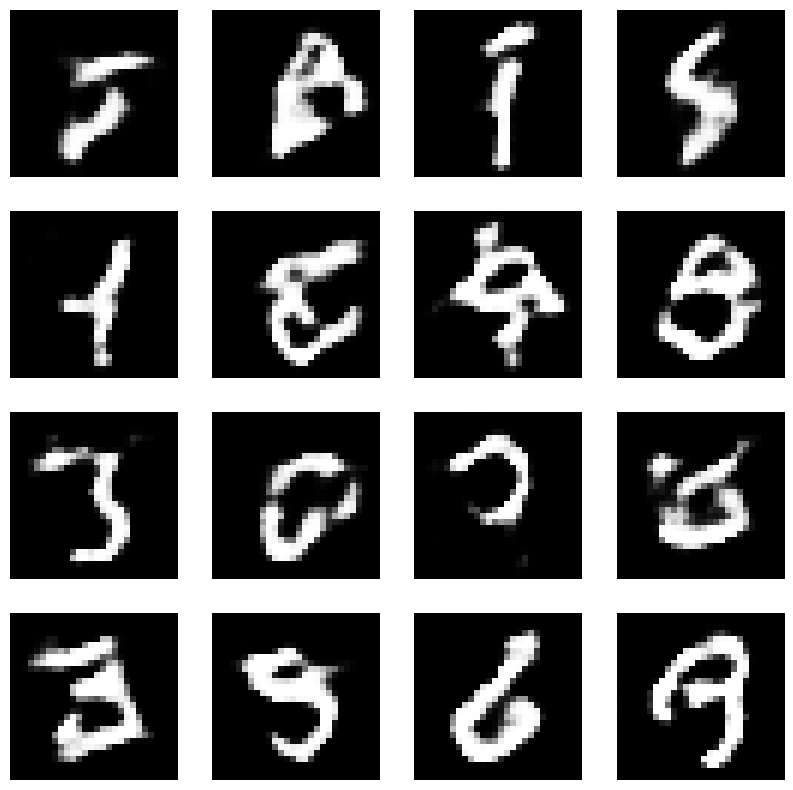

epoch = 82/100


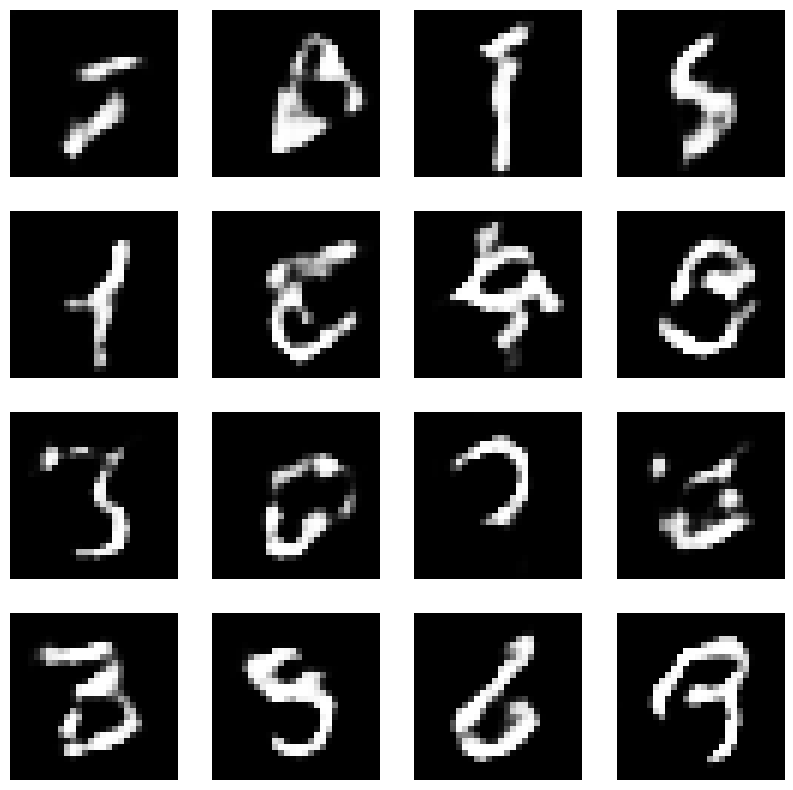

epoch = 83/100


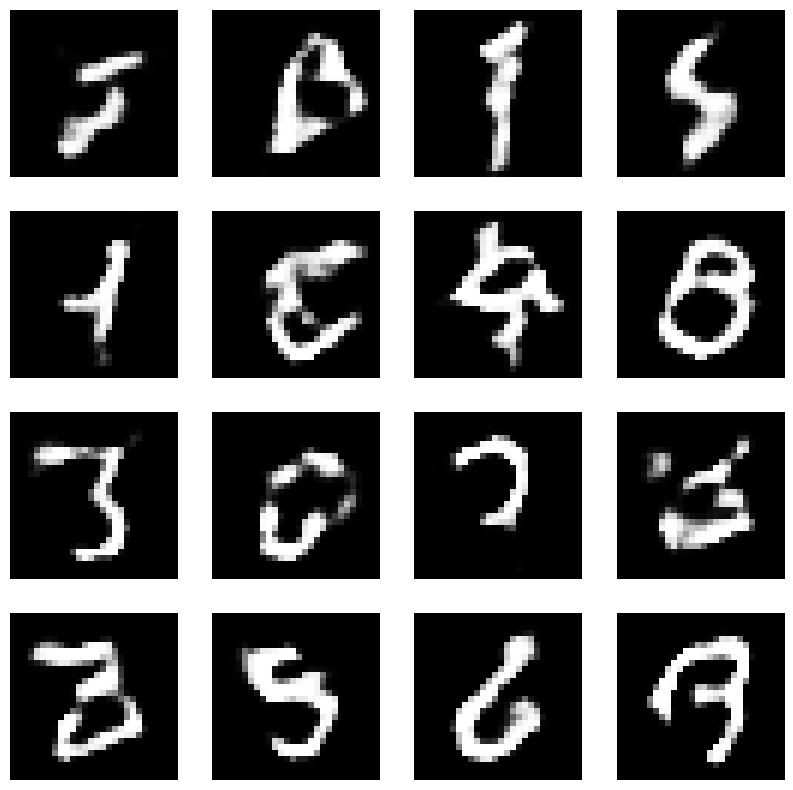

epoch = 84/100


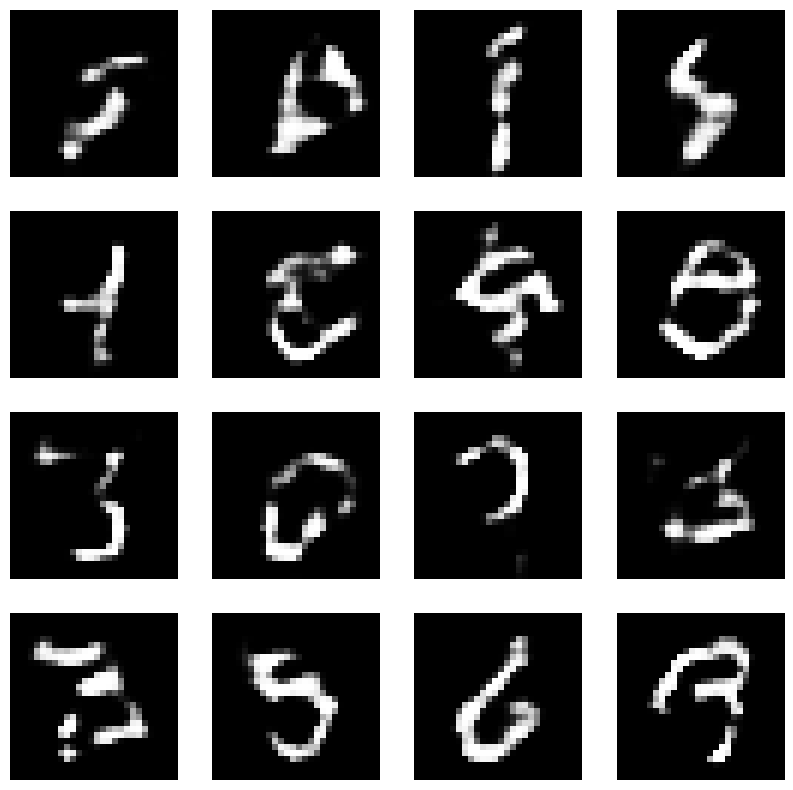

epoch = 85/100


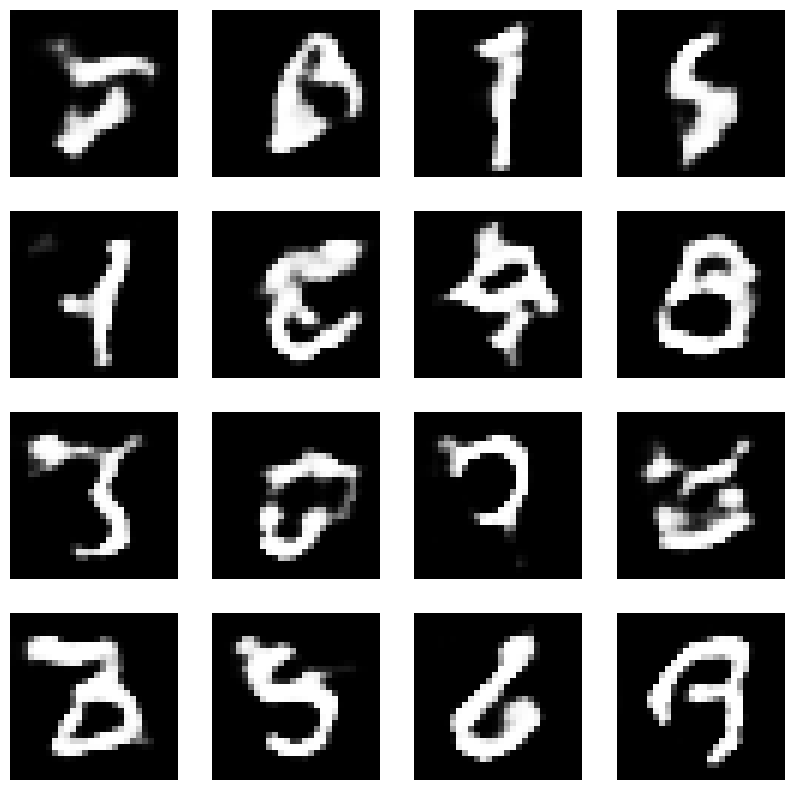

epoch = 86/100


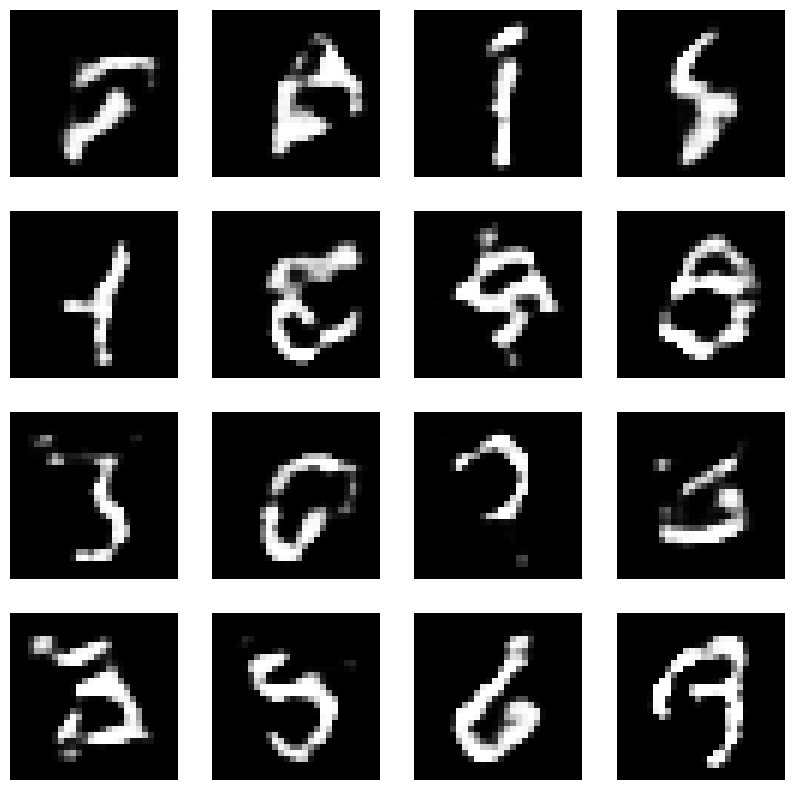

epoch = 87/100


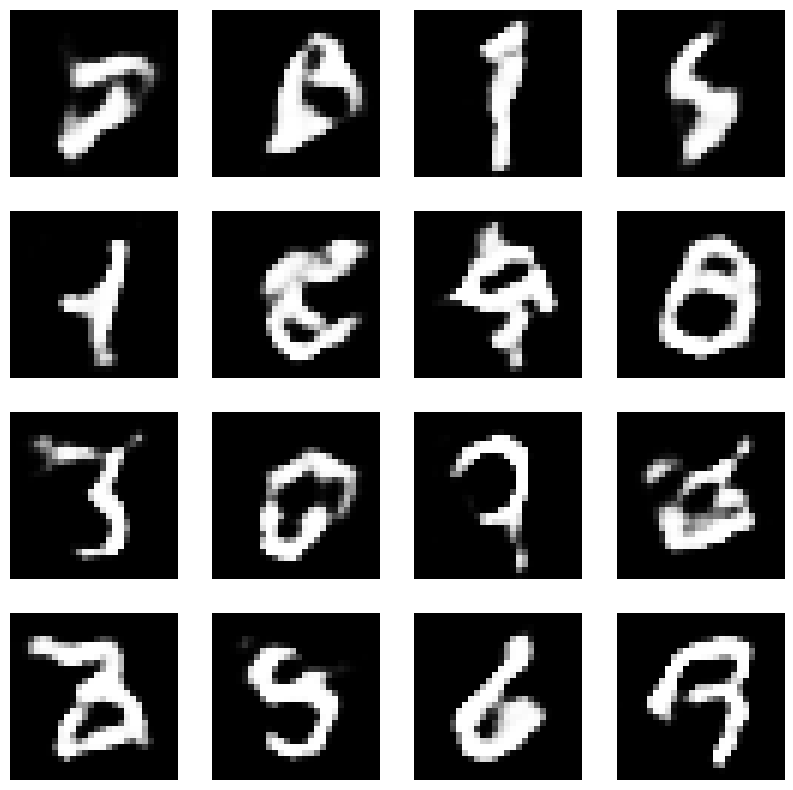

epoch = 88/100


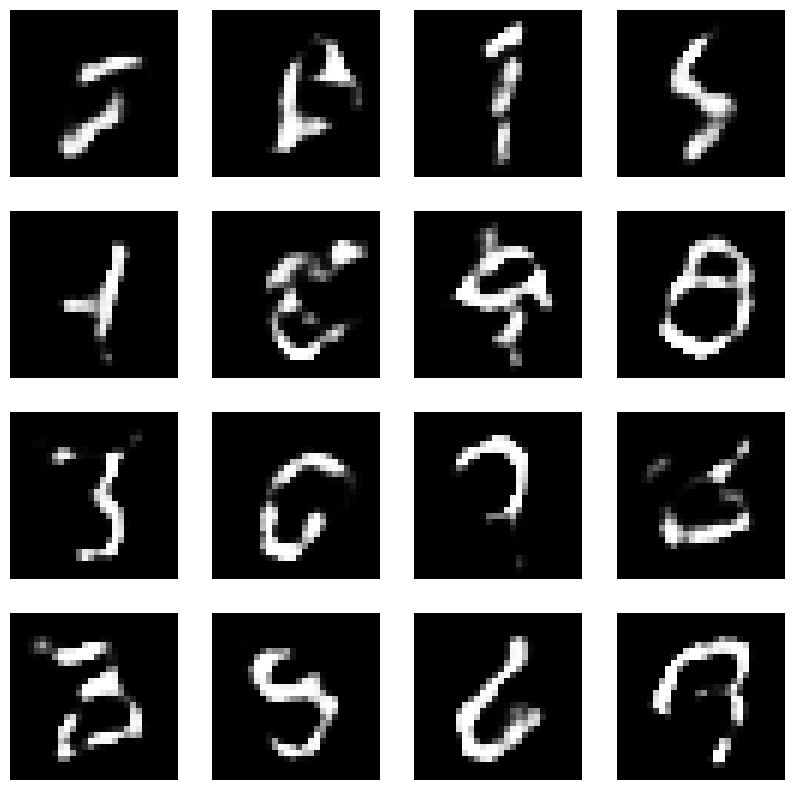

epoch = 89/100


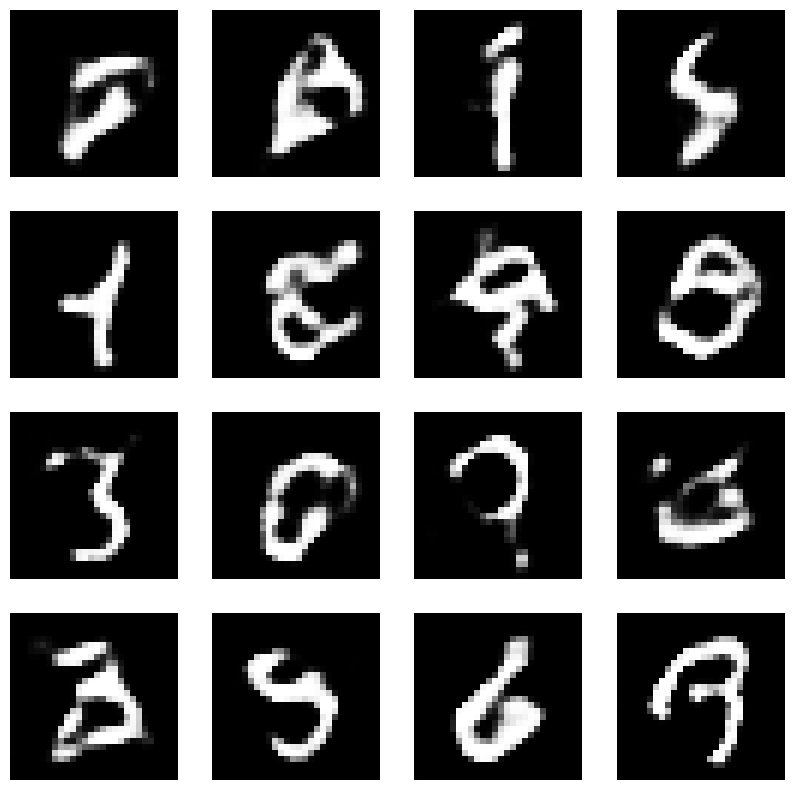

epoch = 90/100


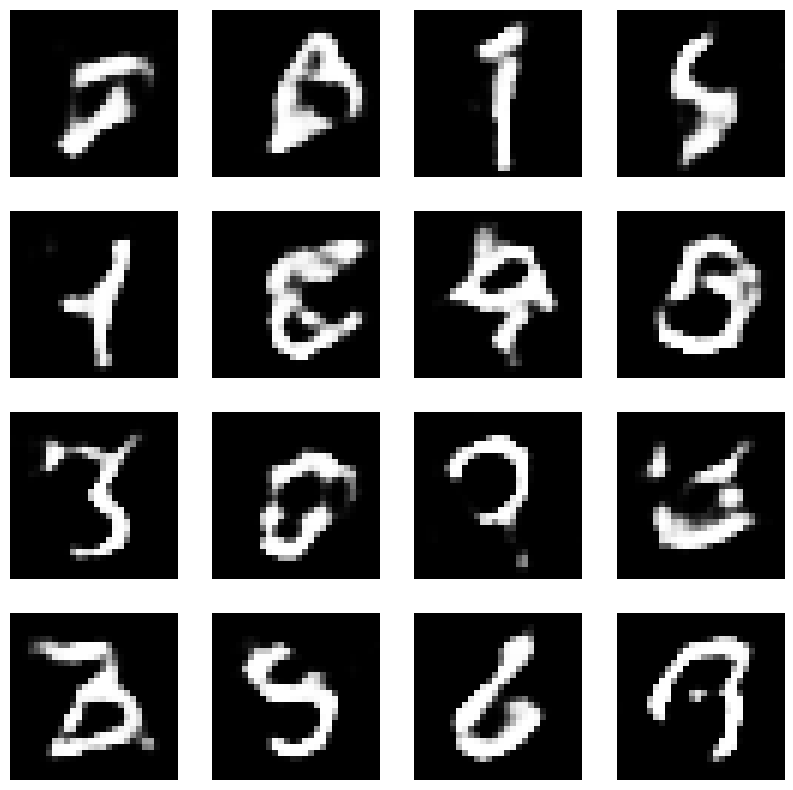

epoch = 91/100


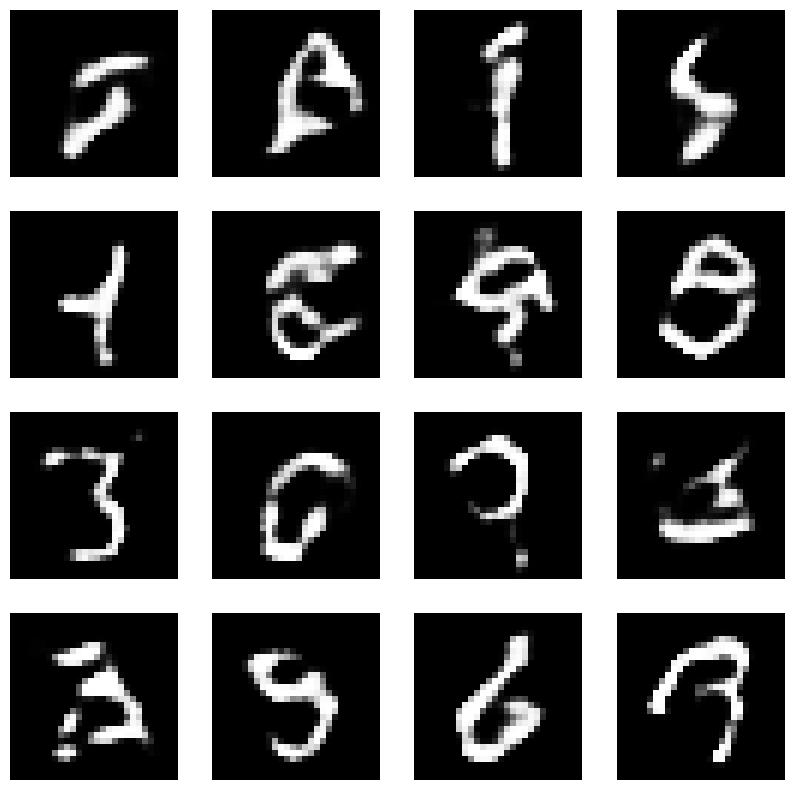

epoch = 92/100


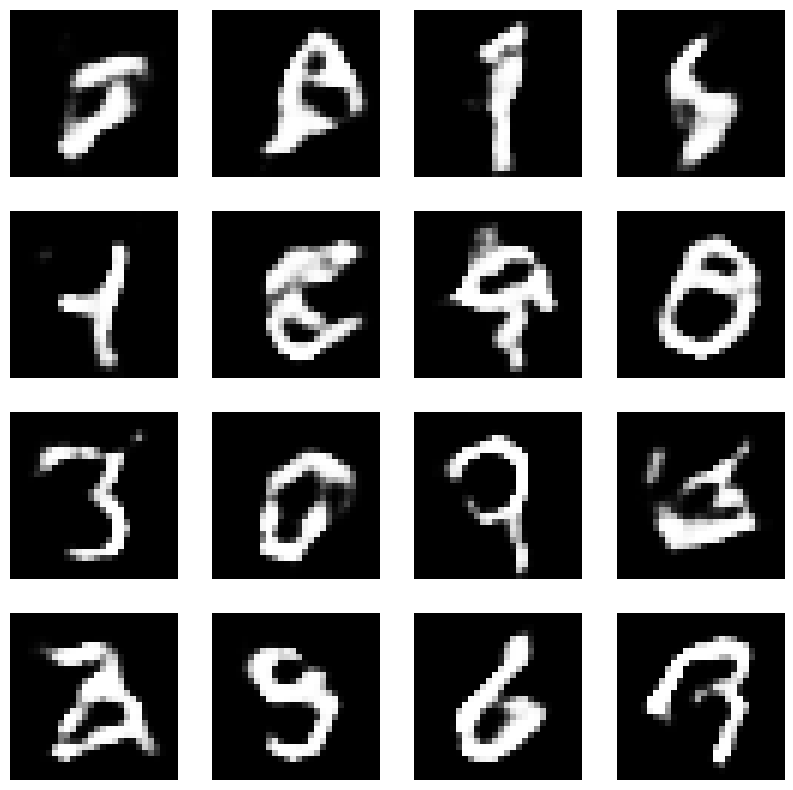

epoch = 93/100


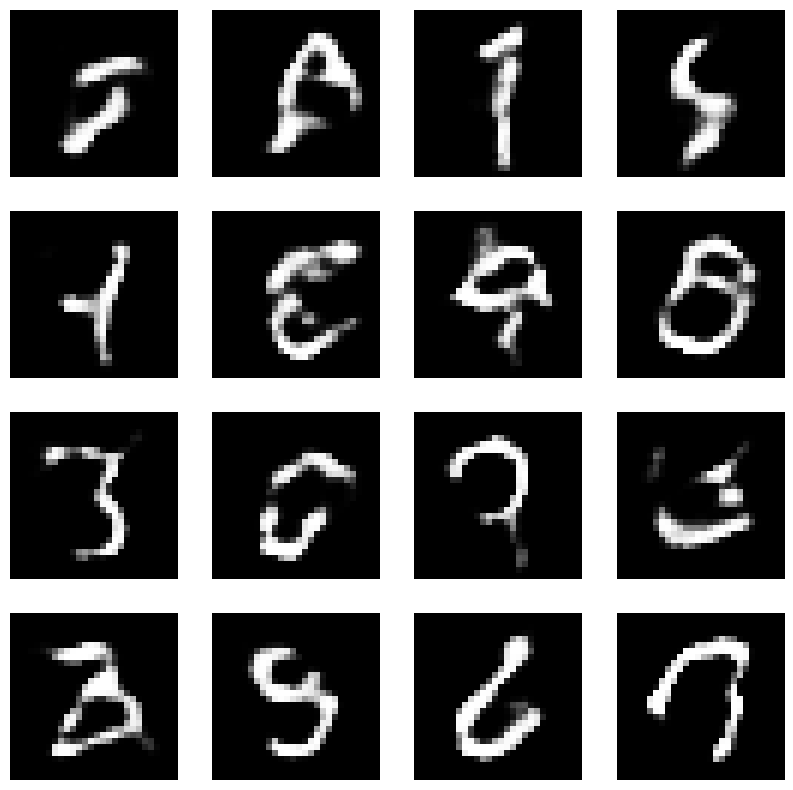

epoch = 94/100


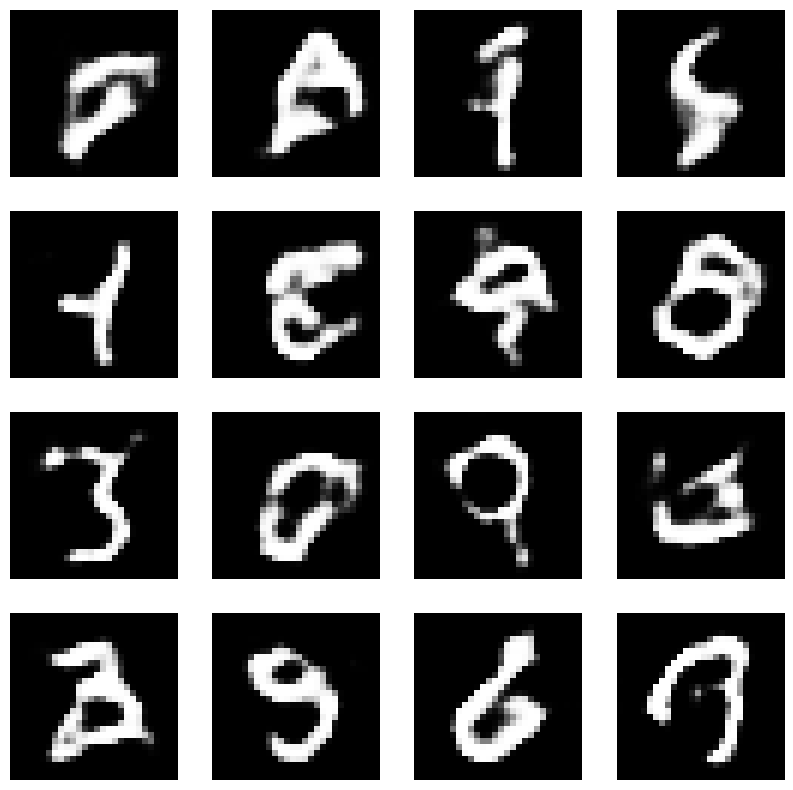

epoch = 95/100


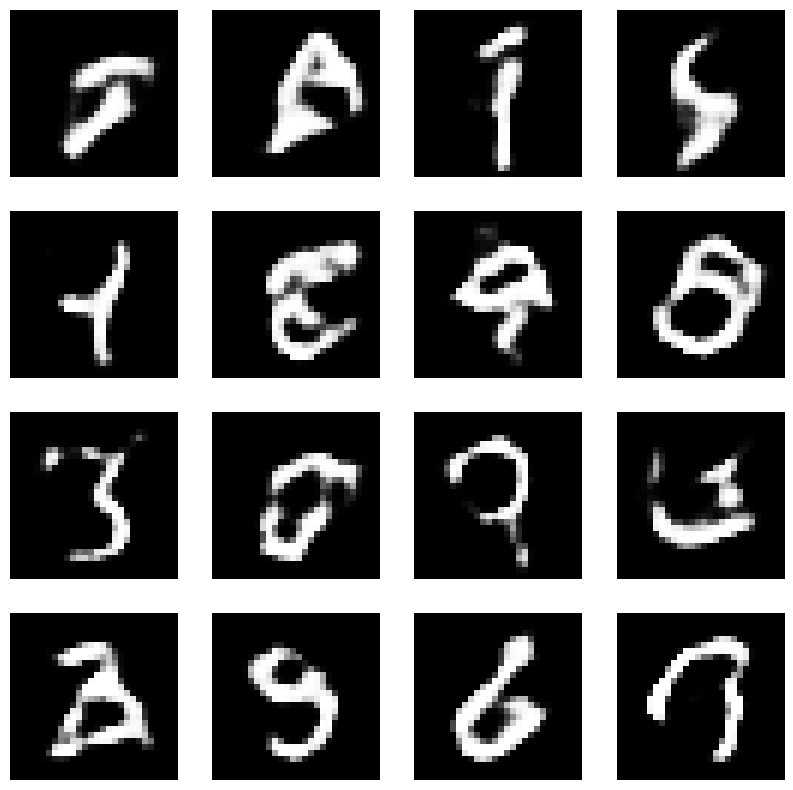

epoch = 96/100


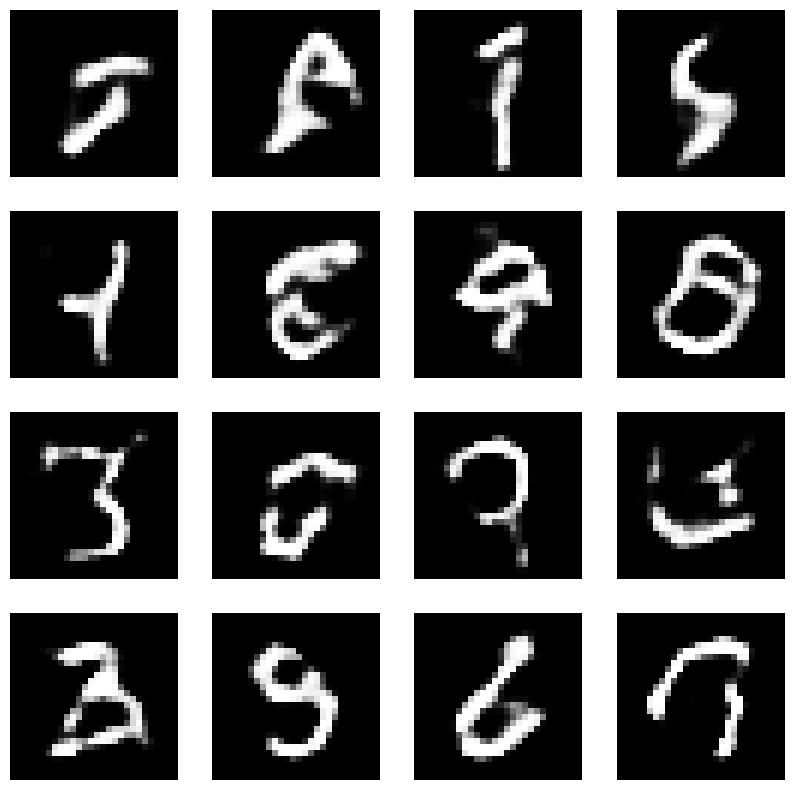

epoch = 97/100


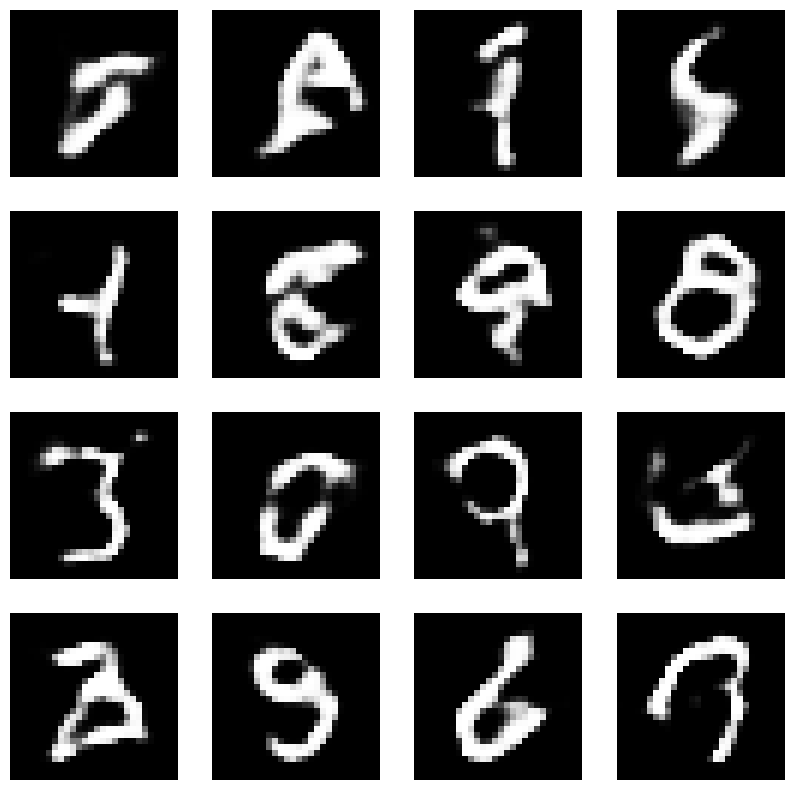

epoch = 98/100


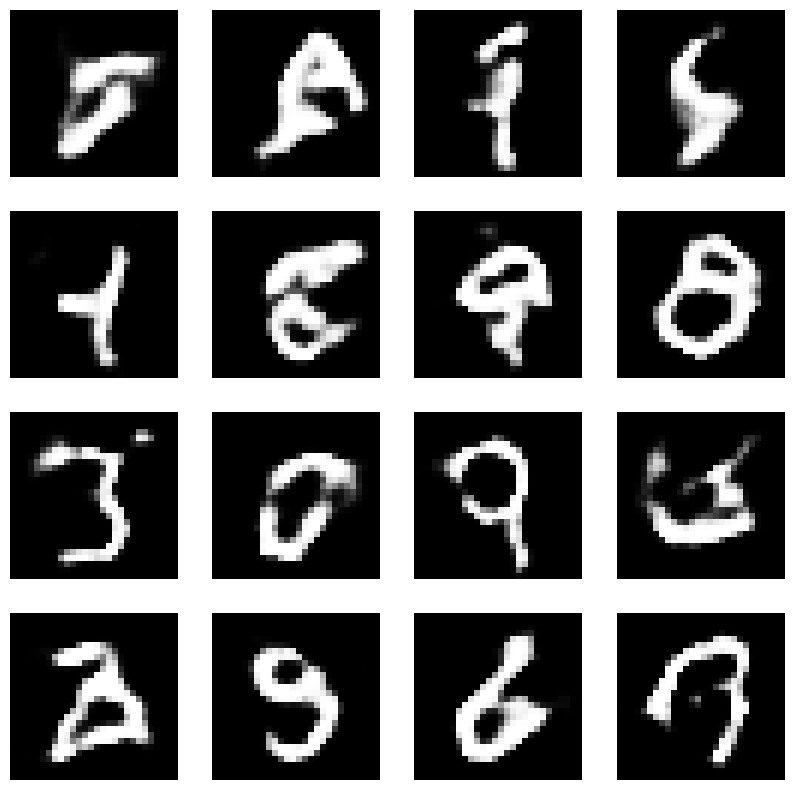

epoch = 99/100


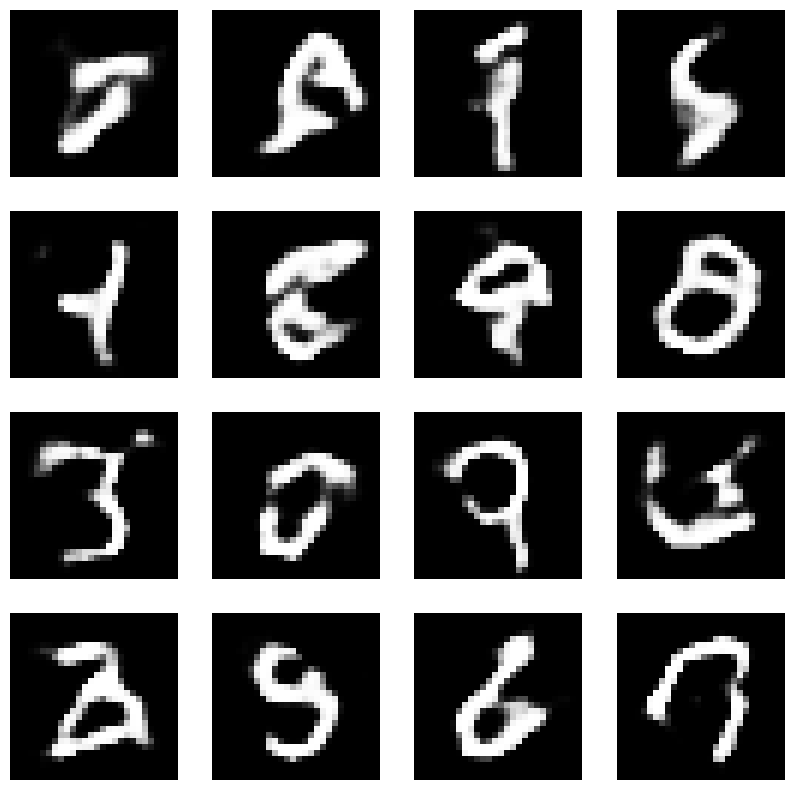

epoch = 100/100


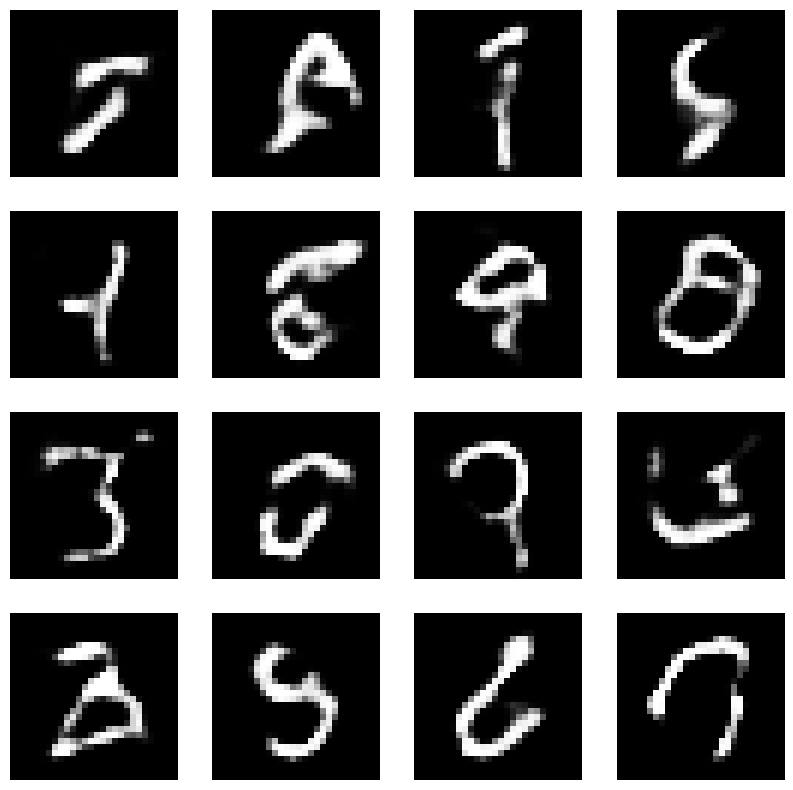

In [65]:
train_gan(X_train, epochs, test_images)